<a target="_blank" href="https://colab.research.google.com/github/cboettig/rl-minicourse/blob/main/challenge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#  RL4Salmon Parameter Tests

In this example, we set up a generic three species, two action problem, and illustrate how to provide a custom population dynamics function, action function, and utility function to represent a caribou conservation objective.  

In [ ]:
# we'll need these packages to begin
!pip install stable-baselines3 plotnine polars sb3_contrib tensorboard


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # change to -1 if you want to use CPU

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# pop = seals, lamprey, salmon
# Salmon Scenario
def dynamics(pop, effort, population_parameters, harvest_fn, p, timestep=1):

    pop = harvest_fn(pop, effort)
    X, Y, Z = pop[0], pop[1], pop[2]

    K_x = p["K_x"] + population_parameters[0]
    K_y = p["K_y"] + population_parameters[1]
    K_z = p["K_z"]
    D = p["D"]

    X += (p["r_x"] * X * (1 - X / K_x )
            - (1 - D) * p["beta"] * Z * (X**2) / (p["v0"]**2 + X**2)
            + p["sigma_x"] * X * np.random.normal()
            )

    Y += (p["r_y"] * Y * (1 - Y  / K_y )
            - D * p["beta"] * Z * (Y**2) / (p["v0"]**2 + Y**2)
            + p["sigma_y"] * Y * np.random.normal()
            )

    Z += p["alpha"] * p["beta"] * Z * (
            (1-D) * (X**2) / (p["v0"]**2 + X**2)
            + D * (Y**2) / (p["v0"]**2 + Y**2)
            ) - p["dH"] * Z +  p["sigma_z"] * Z  * np.random.normal()

    pop = np.array([X, Y, Z], dtype=np.float32)
    pop = np.clip(pop, [0,0,0], [np.Inf, np.Inf, np.Inf])
    return(pop)


Here, we change the sigma values to be negligible at 0.001 so that we can better visualize the underlying patterns in our environment.

In [ ]:
initial_pop = [0.5, 0.5, 0.2]


parameters = {
"r_x": np.float32(0.13),
"r_y": np.float32(0.2),
"r_z": np.float32(0.05),
"K_x": np.float32(1),
"K_y": np.float32(1),
"K_z": np.float32(1),
"beta": np.float32(.1),
"v0":  np.float32(0.1),
"D": np.float32(0.8),
"tau_yx": 0,
"tau_xy": 0,
"alpha": np.float32(.4),
"dH": np.float32(0.03),
"sigma_x": np.float32(0.001),
"sigma_y": np.float32(0.001),
"sigma_z": np.float32(0.001)
}


We must also define the dynamics of the action, a 'harvest' or culling function.  In this scenario, we imagine that we can cull either the salmon or pinniped population (or both).  We assume our control action introduces a percent mortality equal to the control effort applied times a catachability coefficient:

In [ ]:
def harvest(pop, effort):
    q0 = 0.5 # catchability coefficients -- erradication is impossible
    q2 = 0.5
    pop[0] = pop[0] * (1 - effort[0] * q0) # pop 0, seals
    pop[2] = pop[2] * (1 - effort[1] * q2) # pop 2, salmon
    return pop


Lastly, we need to define the utility or reward derived from taking these actions under this population state.  In this scenario, our population control actions are costly, while we acrue a benefit proportional to the size of the current salmon population:

In [ ]:
def utility(pop, effort):
    benefits = 0.5 * pop[1] # benefit from Salmon
    costs = .00001 * (effort[0] + effort[1]) # cost to culling
    if np.any(pop <= 0.01):
        benefits -= 1
    return benefits - costs




To simulate our environment and allow RL algorithms to train on this environment, we define a simple python class using the gym module.  This class defines the possible action space as two continuously-valued action variables (culling effort of salmon and pinnipeds respectively), and three continuously valued state variables (population of salmon, lamprey and pinnipeds).  To improve performance of RL training, it is necessary to transform the continuous space to -1, 1

In [ ]:
import gymnasium as gym

class s3a2(gym.Env):
    """A 3-species ecosystem model with two control actions"""
    def __init__(self, config=None):
        config = config or {}

        ## these parameters may be specified in config
        self.Tmax = config.get("Tmax", 10000)
        self.threshold = config.get("threshold", np.float32(1e-4))
        self.init_sigma = config.get("init_sigma", np.float32(1e-3))
        self.training = config.get("training", True)
        self.initial_pop = config.get("initial_pop", initial_pop)
        self.parameters = config.get("parameters", parameters)
        self.dynamics = config.get("dynamics", dynamics)
        self.harvest = config.get("harvest", harvest)
        self.utility = config.get("utility", utility)
        self.observe = config.get("observe", lambda state: state) # default to perfectly observed case
        self.bound = 2 * self.parameters["K_x"]

        self.action_space = gym.spaces.Box(
            np.array([-1, -1, 0, 0], dtype=np.float32),
            np.array([1, 1, 0.1, 0.1], dtype=np.float32),
            dtype = np.float32
        )
        self.observation_space = gym.spaces.Box(
            np.array([-1, -1, -1], dtype=np.float32),
            np.array([1, 1, 1], dtype=np.float32),
            dtype=np.float32,
        )
        self.reset(seed=config.get("seed", None))


    def reset(self, *, seed=None, options=None):
        self.timestep = 0
        self.initial_pop += np.multiply(self.initial_pop, np.float32(self.init_sigma * np.random.normal(size=3)))
        self.state = self.state_units(self.initial_pop)
        info = {}
        return self.observe(self.state), info


    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        pop = self.population_units(self.state) # current state in natural units
        human_actions = action[:2]
        pop_params = action[2:]
        effort = (human_actions + 1.) / 2

        # harvest and recruitment
        reward = self.utility(pop, effort)
        nextpop = self.dynamics(pop, effort, pop_params, self.harvest, self.parameters, self.timestep)

        self.timestep += 1
        terminated = bool(self.timestep > self.Tmax)

        # in training mode only: punish for population collapse
        if any(pop <= self.threshold) and self.training:
            terminated = True
            reward -= 50/self.timestep

        self.state = self.state_units(nextpop) # transform into [-1, 1] space
        observation = self.observe(self.state) # same as self.state
        return observation, reward, terminated, False, {}

    def state_units(self, pop):
        self.state = 2 * pop / self.bound - 1
        self.state = np.clip(self.state,
                             np.repeat(-1, self.state.__len__()),
                             np.repeat(1, self.state.__len__()))
        return np.float32(self.state)

    def population_units(self, state):
        pop = (state + 1) * self.bound /2
        return np.clip(pop,
                       np.repeat(0, pop.__len__()),
                       np.repeat(np.Inf, pop.__len__()))

# verify that the environment is defined correctly
from stable_baselines3.common.env_checker import check_env
env = s3a2()
check_env(env, warn=True)


Here, we create a function to run a simulation of an episode by inputting an action, plotting the graph of the population proportions over time, and printing the end population proportions.

In [ ]:
from scipy.optimize import minimize
import polars as pl
from plotnine import ggplot, aes, geom_line

def get_final_pop(df):
  final_pops = df.select(["X", "Y", "Z"]).tail(1)
  return list(final_pops.to_numpy()[0])

def obtain_simulated_data(action, timesteps=env.Tmax, env=env):
  df = []
  episode_reward = 0
  observation, _ = env.reset()
  for t in range(timesteps):
    obs = env.population_units(observation) # natural units
    df.append([t, episode_reward, *obs])
    observation, reward, terminated, done, info = env.step(action)
    episode_reward += reward

  df = pl.DataFrame(df, schema=["t", "reward", "X", "Y", "Z"])
  return df

def plot_simulation(df):
  cols = ["t", "reward", "X", "Y", "Z"]

  dfl = (pl.DataFrame(df, schema=cols).
          select(["t", "X", "Y", "Z"]).
          melt("t")
        )
  p = ggplot(dfl, aes("t", "value", color="variable")) + geom_line()
  display(p)

def run_simulation(action, timesteps=env.Tmax, env=env):
  df = obtain_simulated_data(action, timesteps, env)
  plot_simulation(df)
  display_final_pop(get_final_pop(df))

def display_final_pop(pop):
  salmon_str = f"Salmon Population: {pop[0]:.2f}"
  lamprey_str = f"Lamprey Population: {pop[1]:.2f}"
  pinniped_str = f"Pinniped Population: {pop[2]:.2f}"
  print(salmon_str + "\n" + lamprey_str + "\n" + pinniped_str)

Now, this is where the notebook branches out from the previous one mainly. Here, we create a zero action in which the normalized human actions take a value of -1 and the non-normalized parameter changing actions take a value of 0. We run through multiple different timesteps counts from 800 to 10000 taking steps of 800 at each instance and plot the results.

Observe that since the noise is now negligible, we can observe the true pattern that we have modeled by our growth patterns and equations. We see that it is inherently sinusoidal, and so optimization may occur by attempting to achieve either the peaks or troughs of the function during some period of its oscillation.

Timesteps: 800


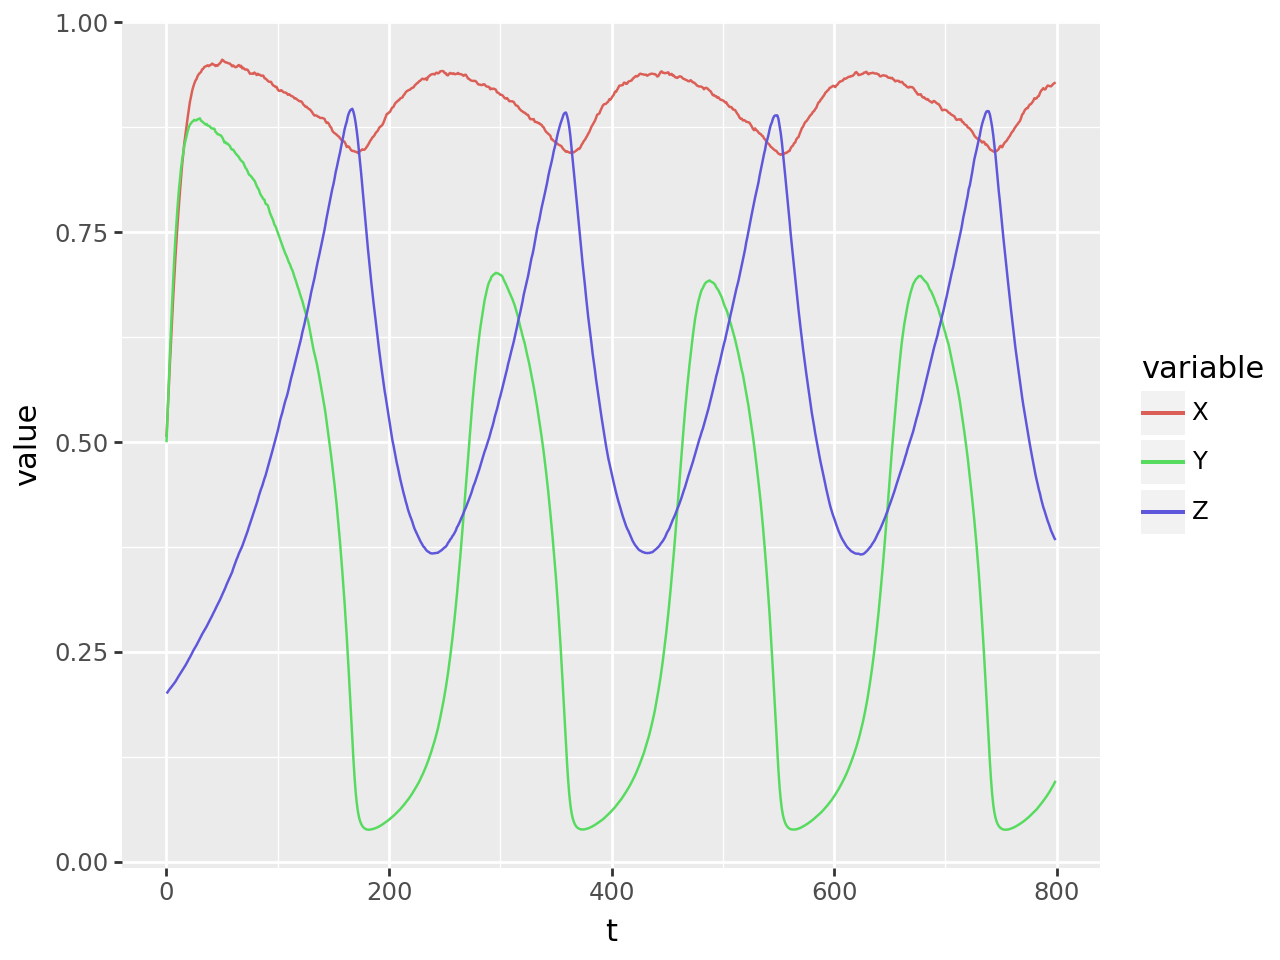

Salmon Population: 0.93
Lamprey Population: 0.10
Pinniped Population: 0.38


Timesteps: 1600


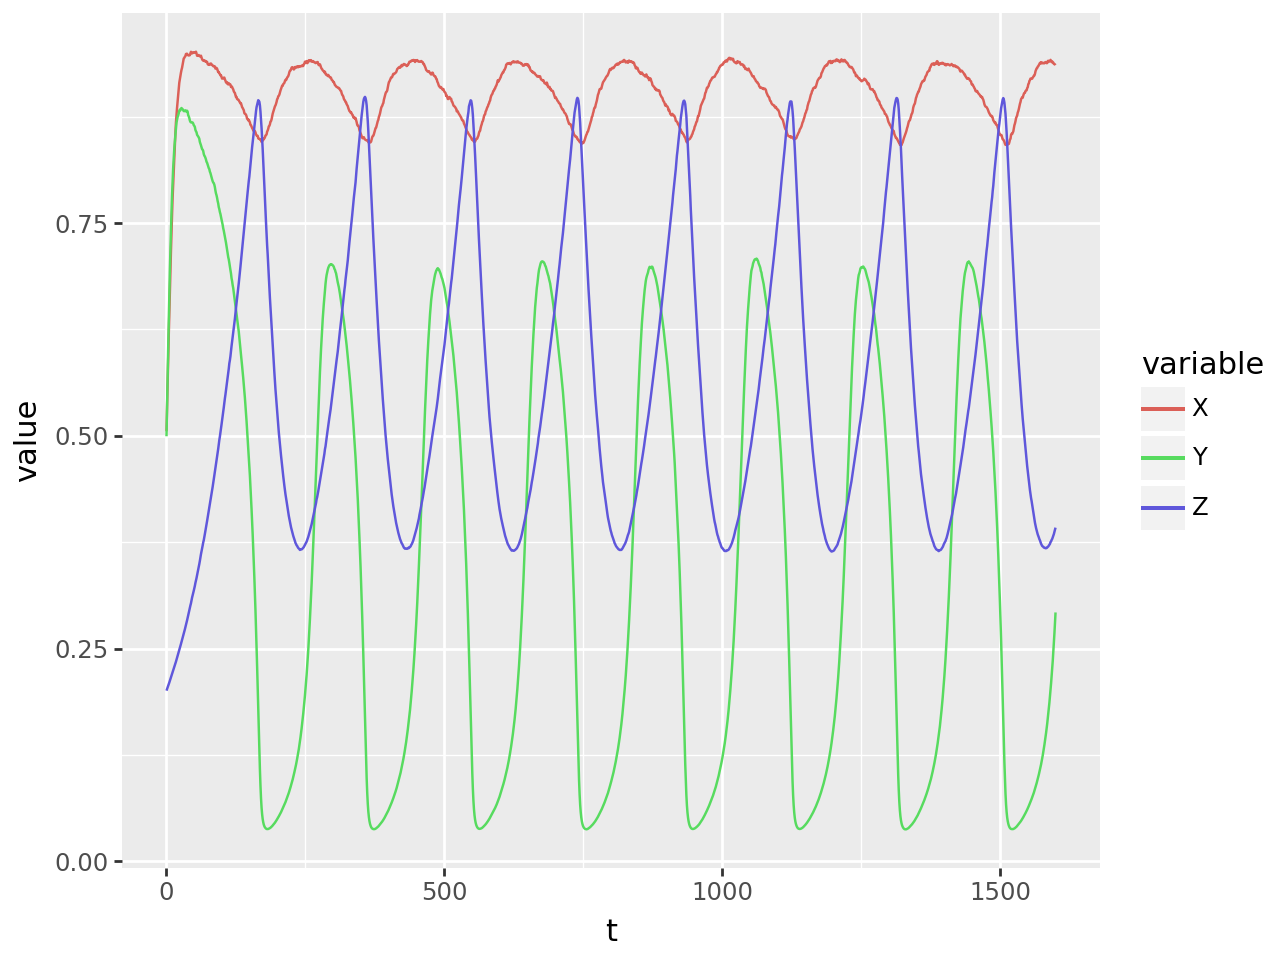

Salmon Population: 0.94
Lamprey Population: 0.29
Pinniped Population: 0.39


Timesteps: 2400


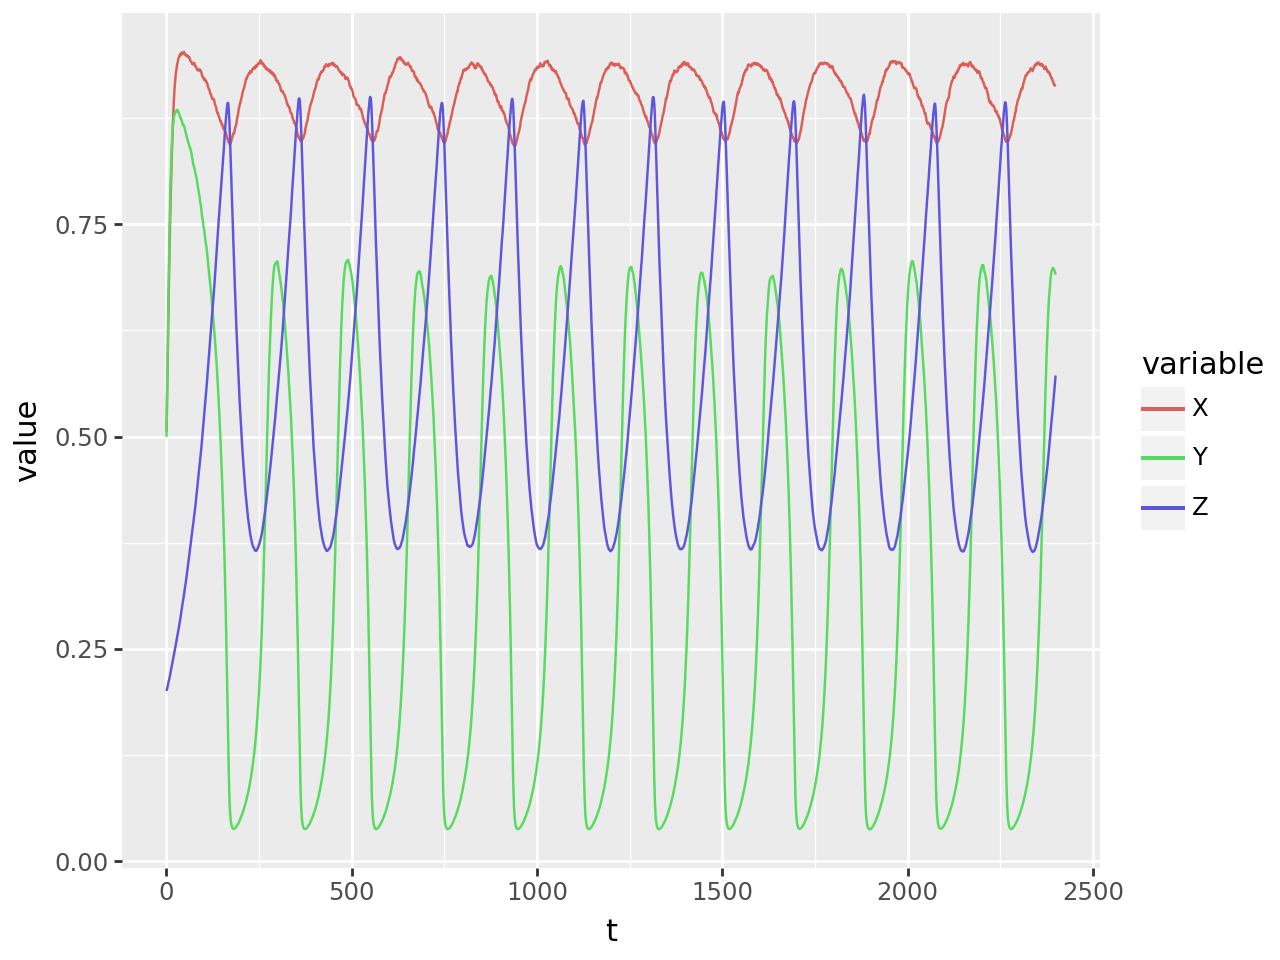

Salmon Population: 0.91
Lamprey Population: 0.69
Pinniped Population: 0.57


Timesteps: 3200


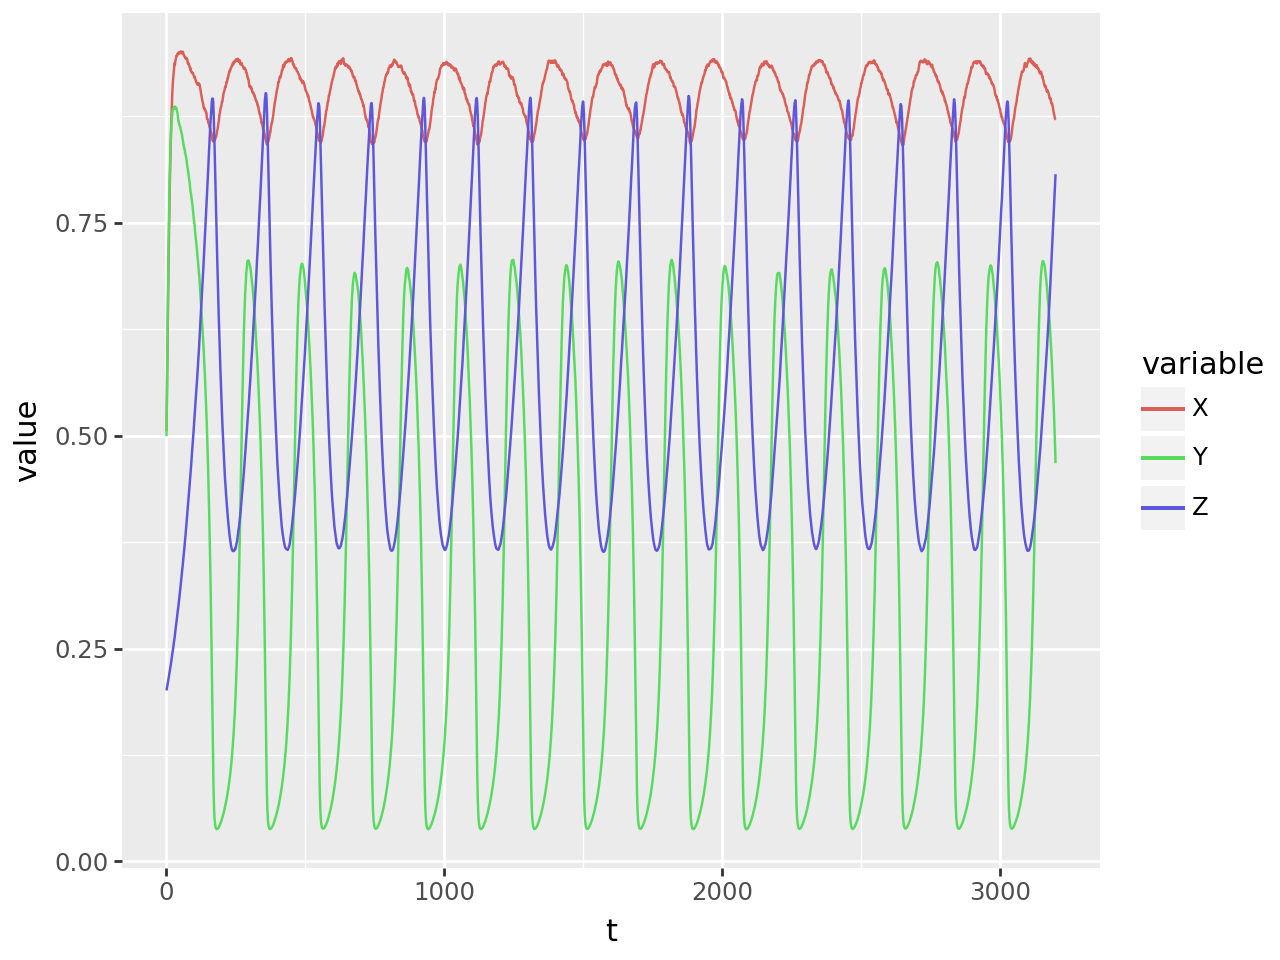

Salmon Population: 0.87
Lamprey Population: 0.47
Pinniped Population: 0.81


Timesteps: 4000


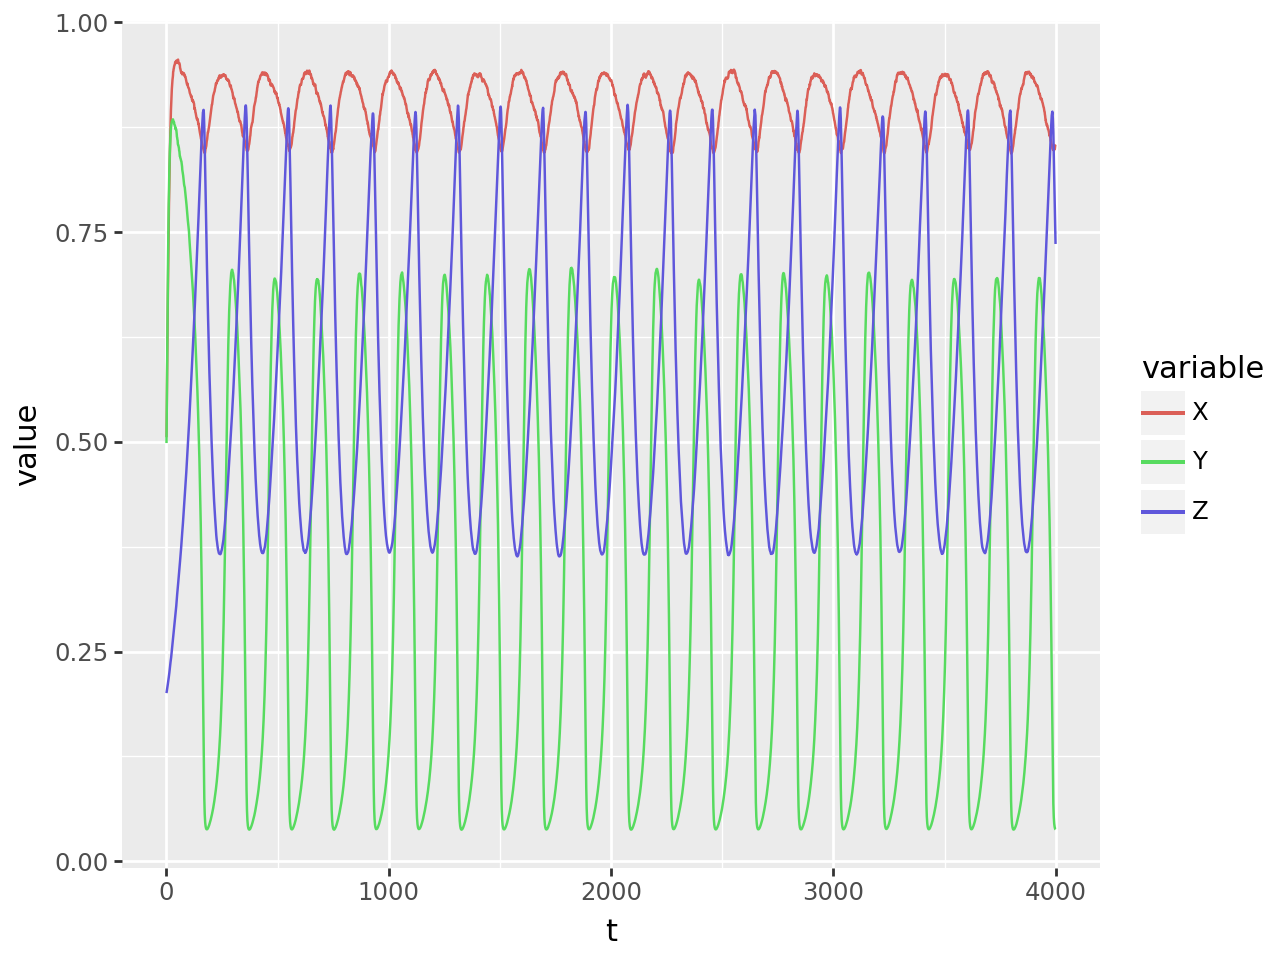

Salmon Population: 0.85
Lamprey Population: 0.04
Pinniped Population: 0.74


Timesteps: 4800


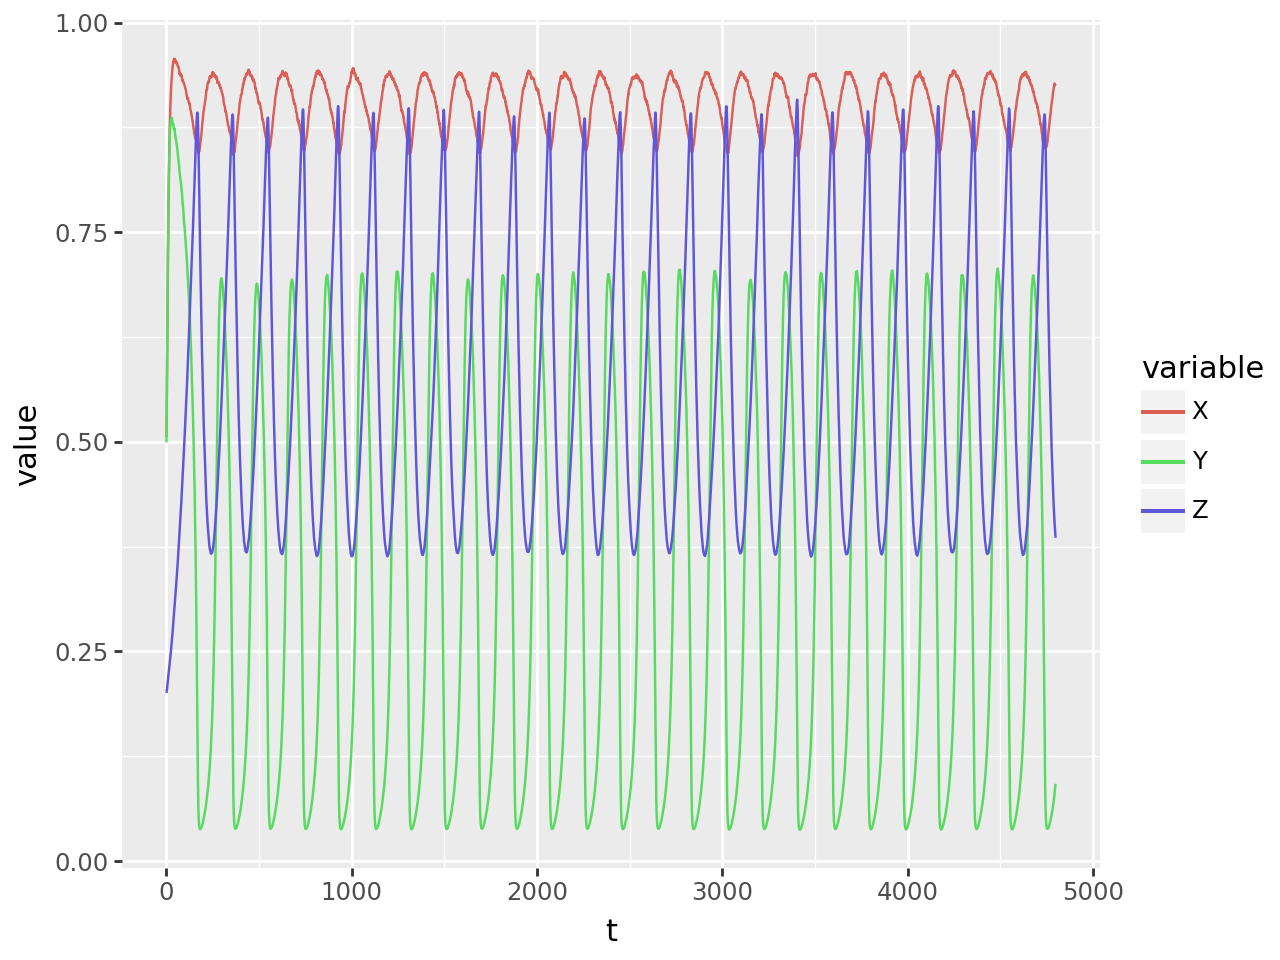

Salmon Population: 0.93
Lamprey Population: 0.09
Pinniped Population: 0.39


Timesteps: 5600


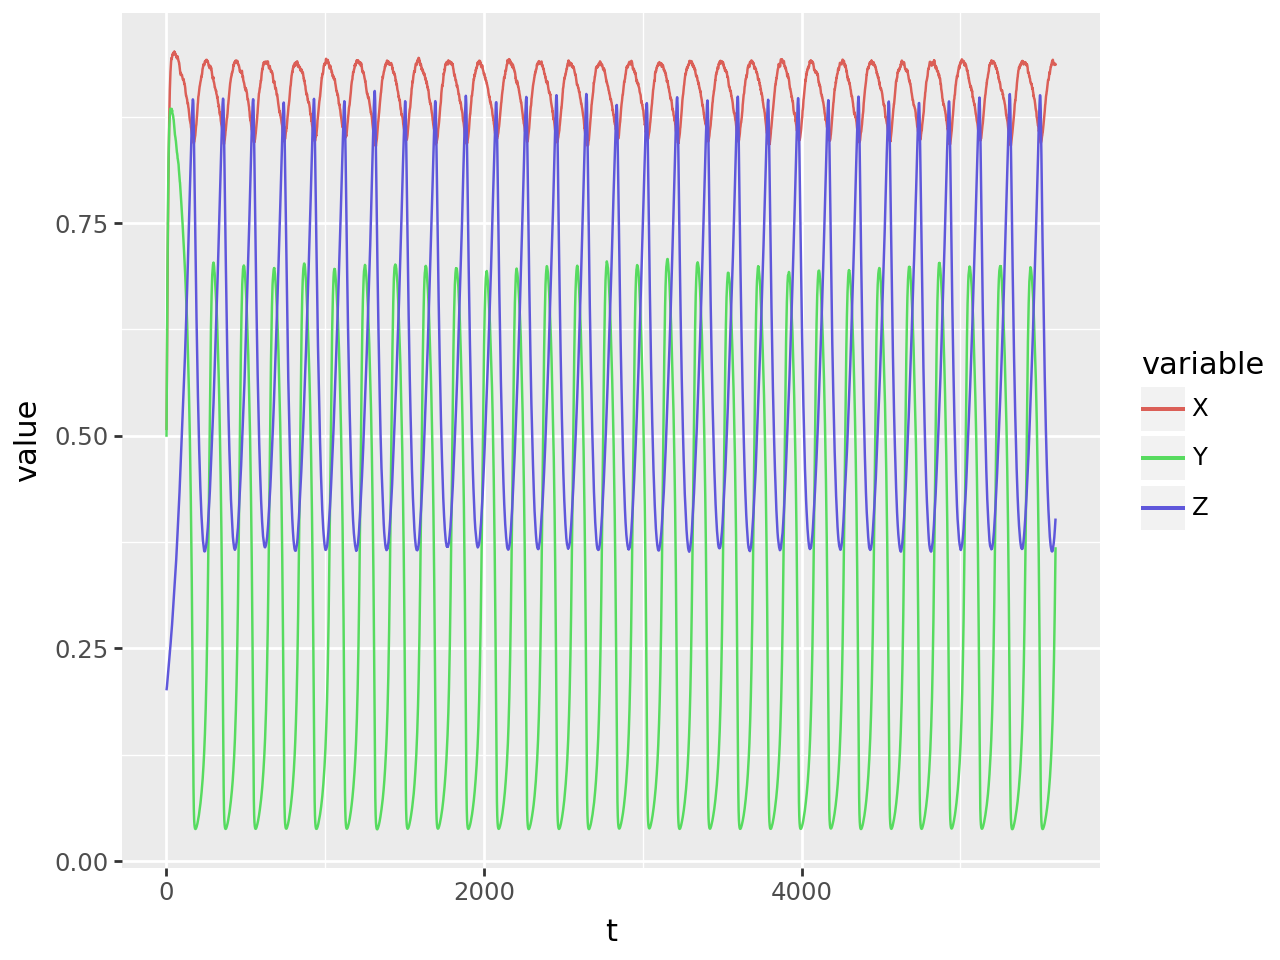

Salmon Population: 0.94
Lamprey Population: 0.37
Pinniped Population: 0.40


Timesteps: 6400


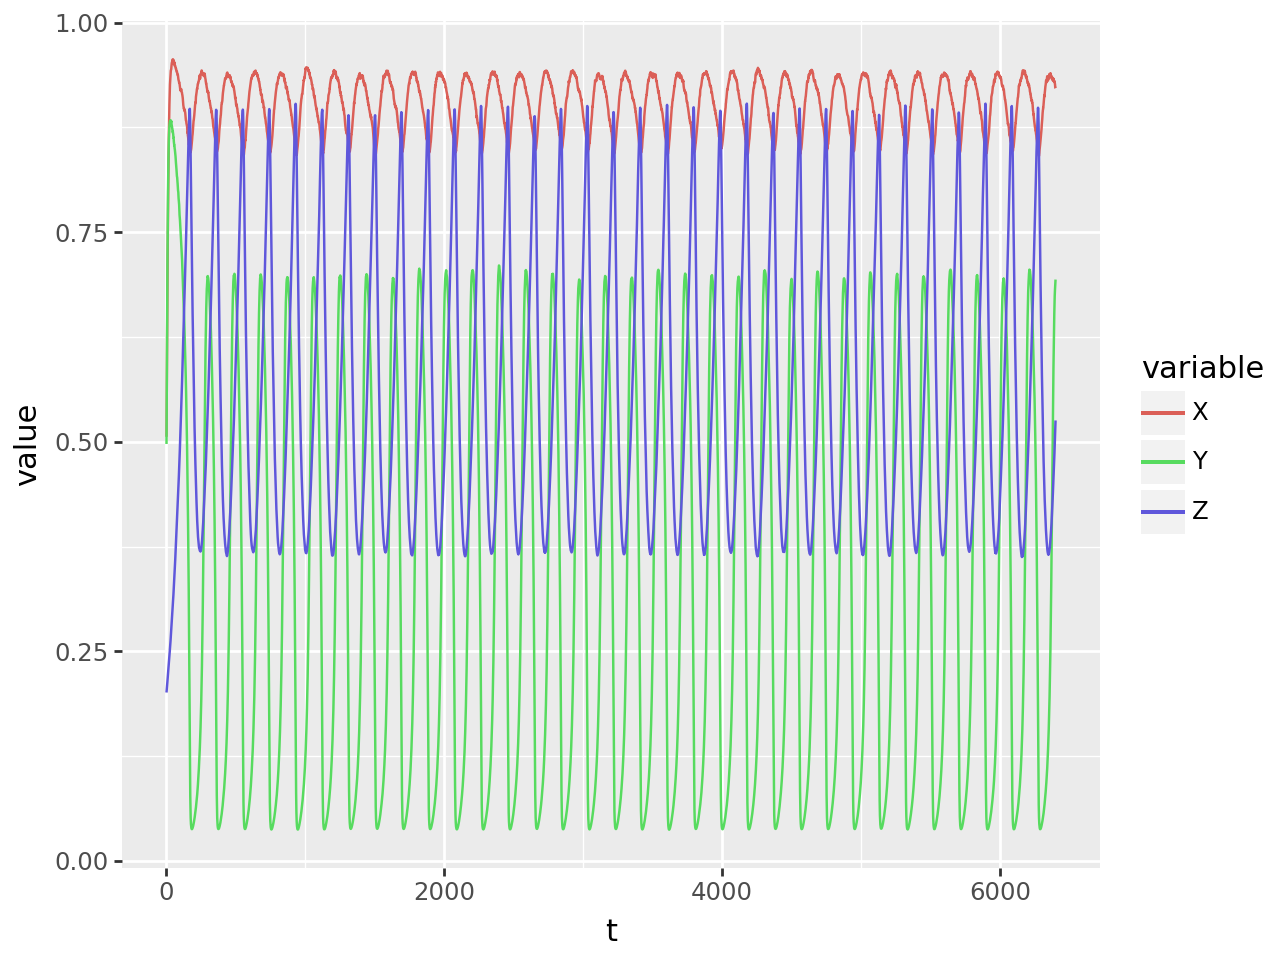

Salmon Population: 0.92
Lamprey Population: 0.69
Pinniped Population: 0.53


Timesteps: 7200


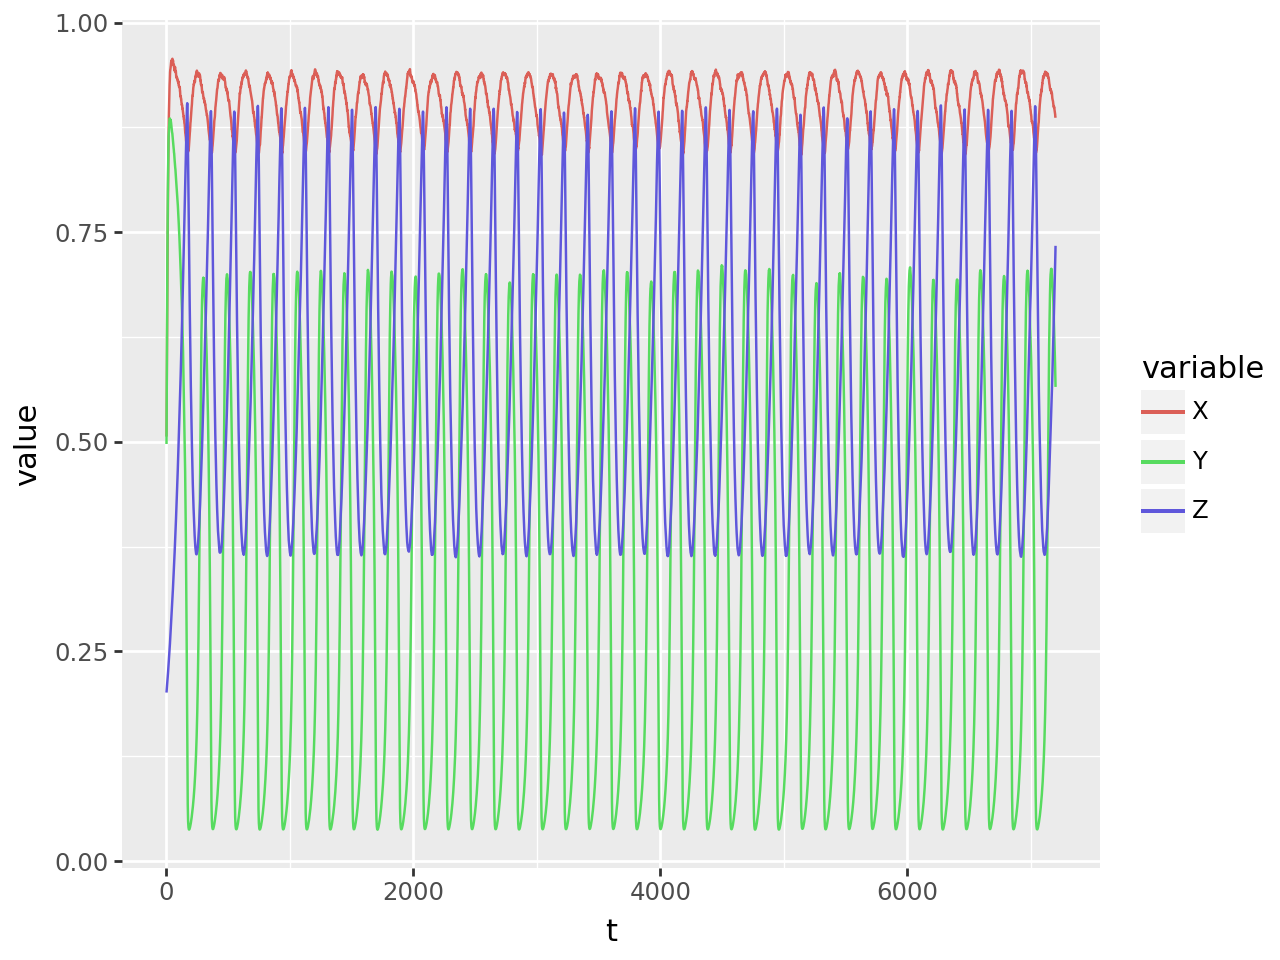

Salmon Population: 0.89
Lamprey Population: 0.57
Pinniped Population: 0.73


Timesteps: 8000


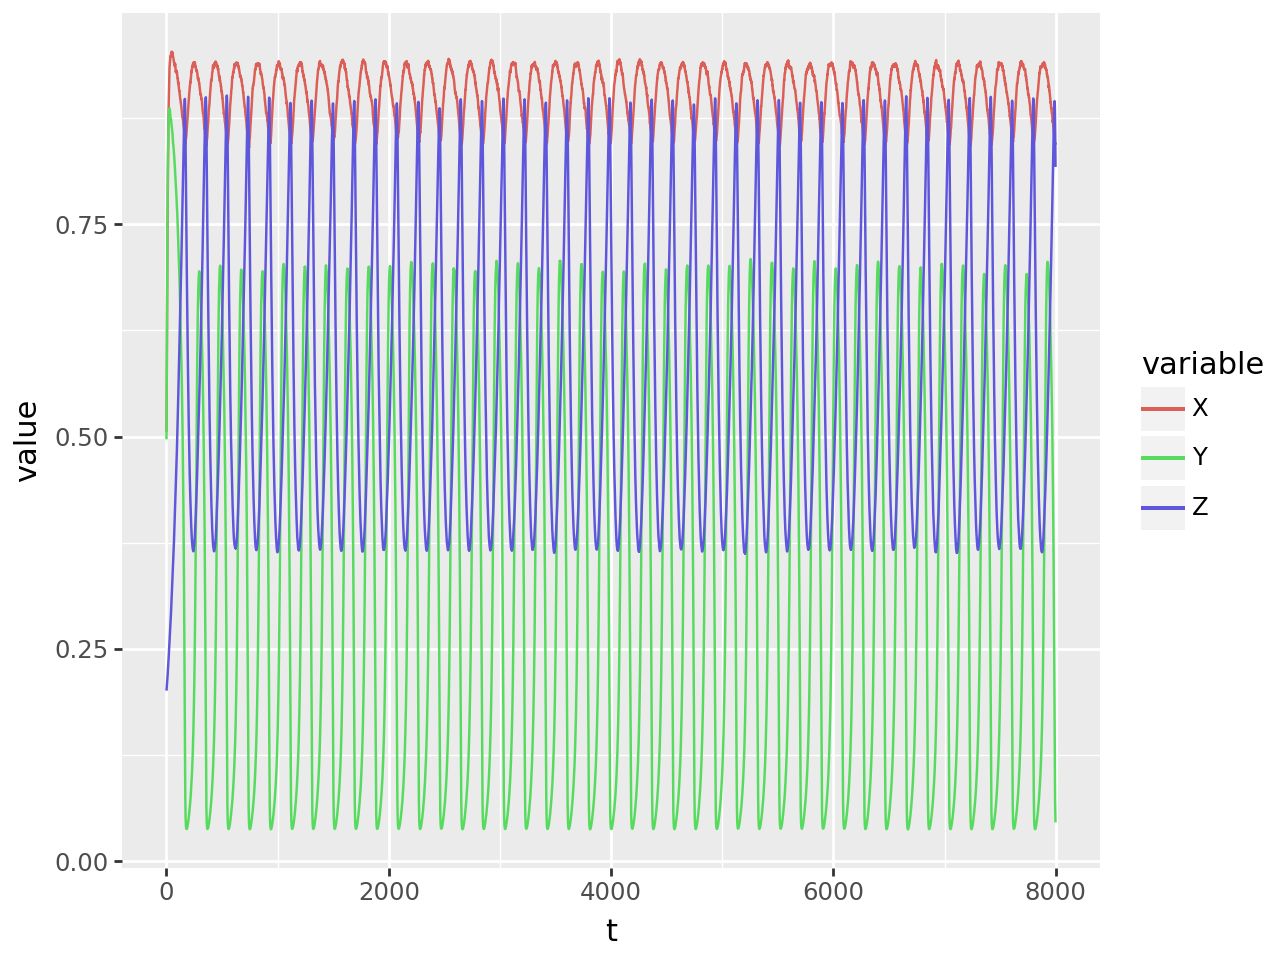

Salmon Population: 0.85
Lamprey Population: 0.05
Pinniped Population: 0.82


Timesteps: 8800


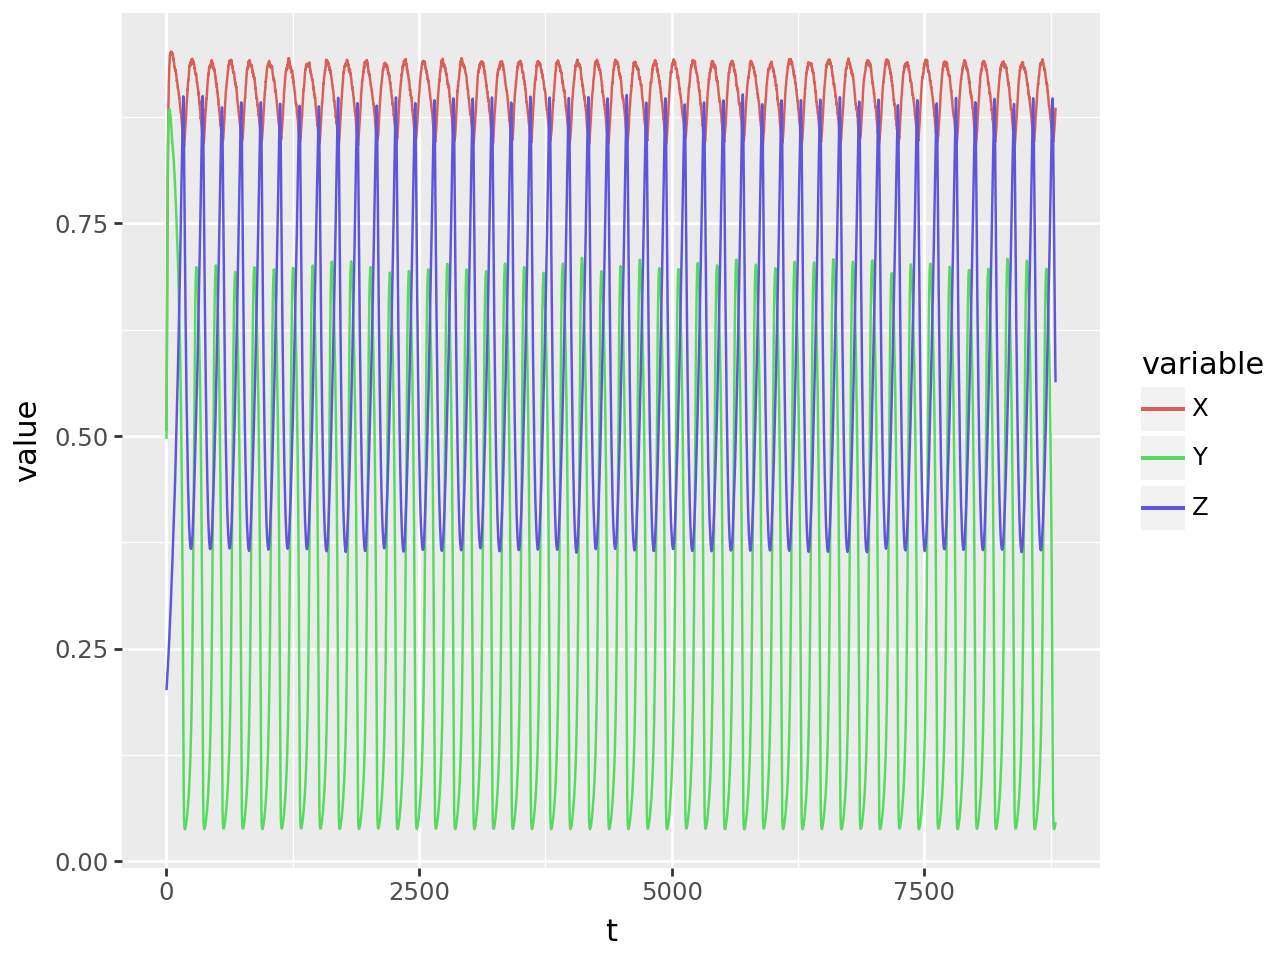

Salmon Population: 0.89
Lamprey Population: 0.05
Pinniped Population: 0.56


Timesteps: 9600


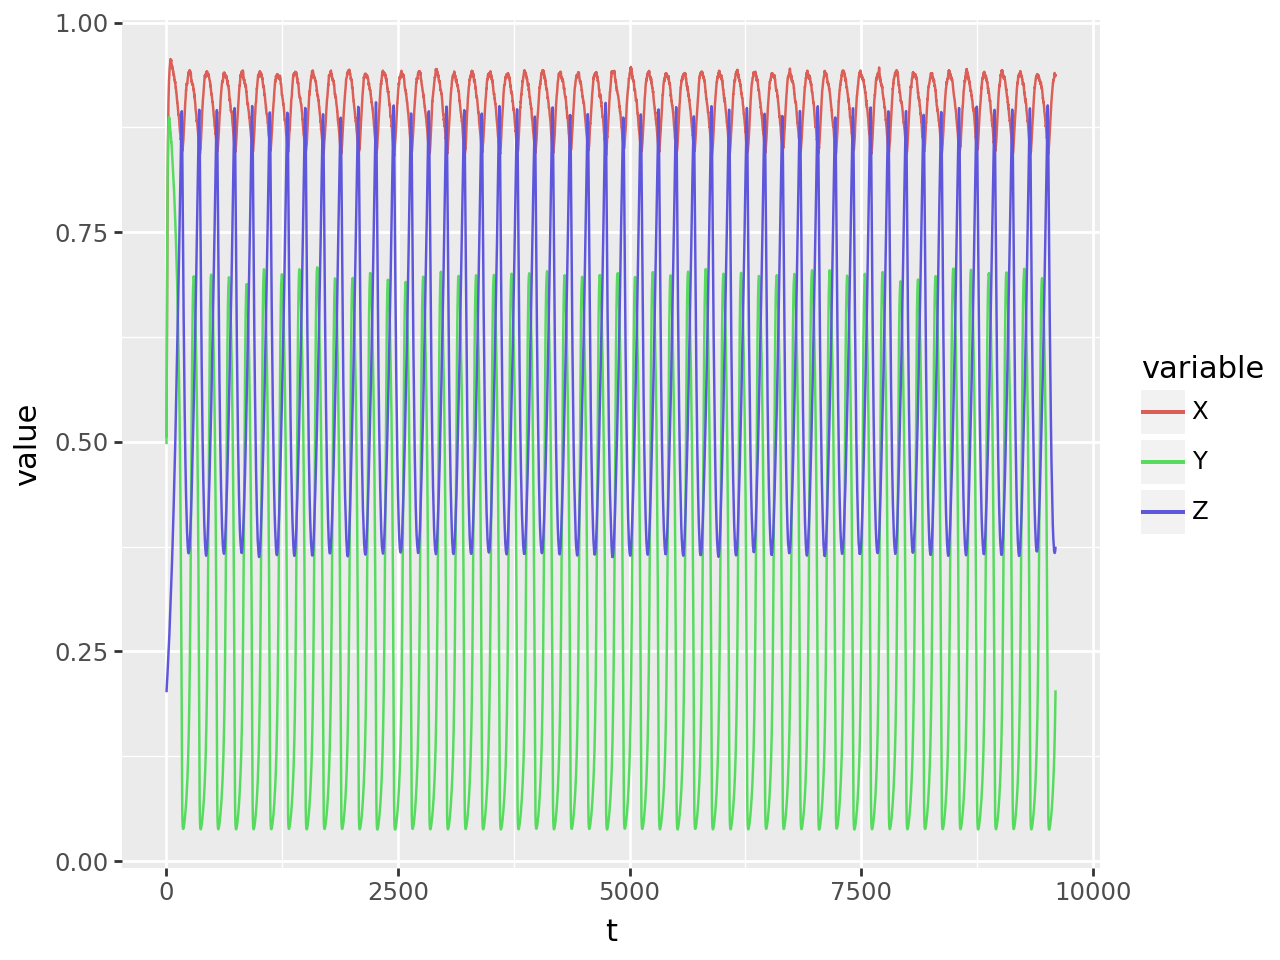

Salmon Population: 0.94
Lamprey Population: 0.20
Pinniped Population: 0.37




In [ ]:
zero_action = [-1, -1, 0, 0]

for timesteps in range(800, 10000, 800):
  print(f"Timesteps: {timesteps}")
  run_simulation(zero_action, timesteps)
  print("\n")

Now, we wish to test the zero action but on environments with different carrying capacity parameters. We create a function to accomplish this task. We use a default of 3200 timesteps and plot carrying capacities from 1 to 1.25 with increments of 0.05.

In [ ]:
def simulate_k_change(timesteps, increment_range, species_K):
  display_dict = {"K_x": "Salmon", "K_y": "Lamprey", "K_z": "Pinniped"}

  for increment in increment_range:
    curr_parameters = parameters.copy()
    curr_parameters[species_K] += increment
    curr_env = s3a2(config={"parameters": curr_parameters})
    print(f"{display_dict[species_K]} Carrying Capacity: {curr_parameters[species_K]}")
    run_simulation(zero_action, timesteps, curr_env)
    print("\n")

increment_range = np.arange(0, 0.26, 0.05)
n_timesteps = 3200

We now test this function on each of the three species' carrying capacities, beginning with salmon, then going to lamprey, and ending with pinnipeds.

For salmon, we see that the end population experiences a steady increasing trend as the carrying capacity increases, signifying an underlying direct correlation, which is logical as a higher carrying capacity should suggest a higher population. Observe that lamprey and pinnipeds' ending populations do not differ greatly if we only change the salmon's carrying capacity, which is logical.

Salmon Carrying Capacity: 1.0


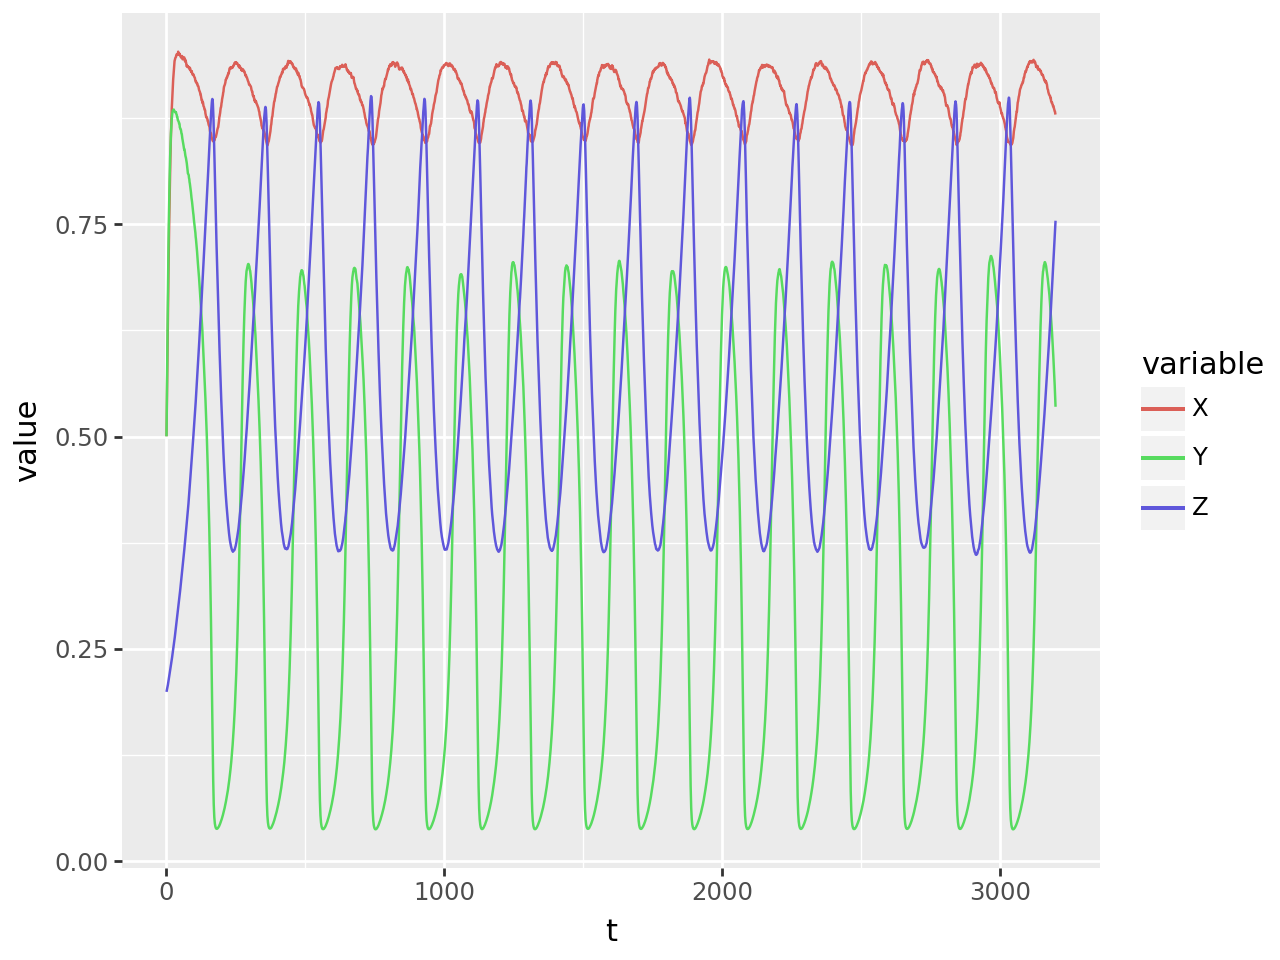

Salmon Population: 0.88
Lamprey Population: 0.54
Pinniped Population: 0.75


Salmon Carrying Capacity: 1.05


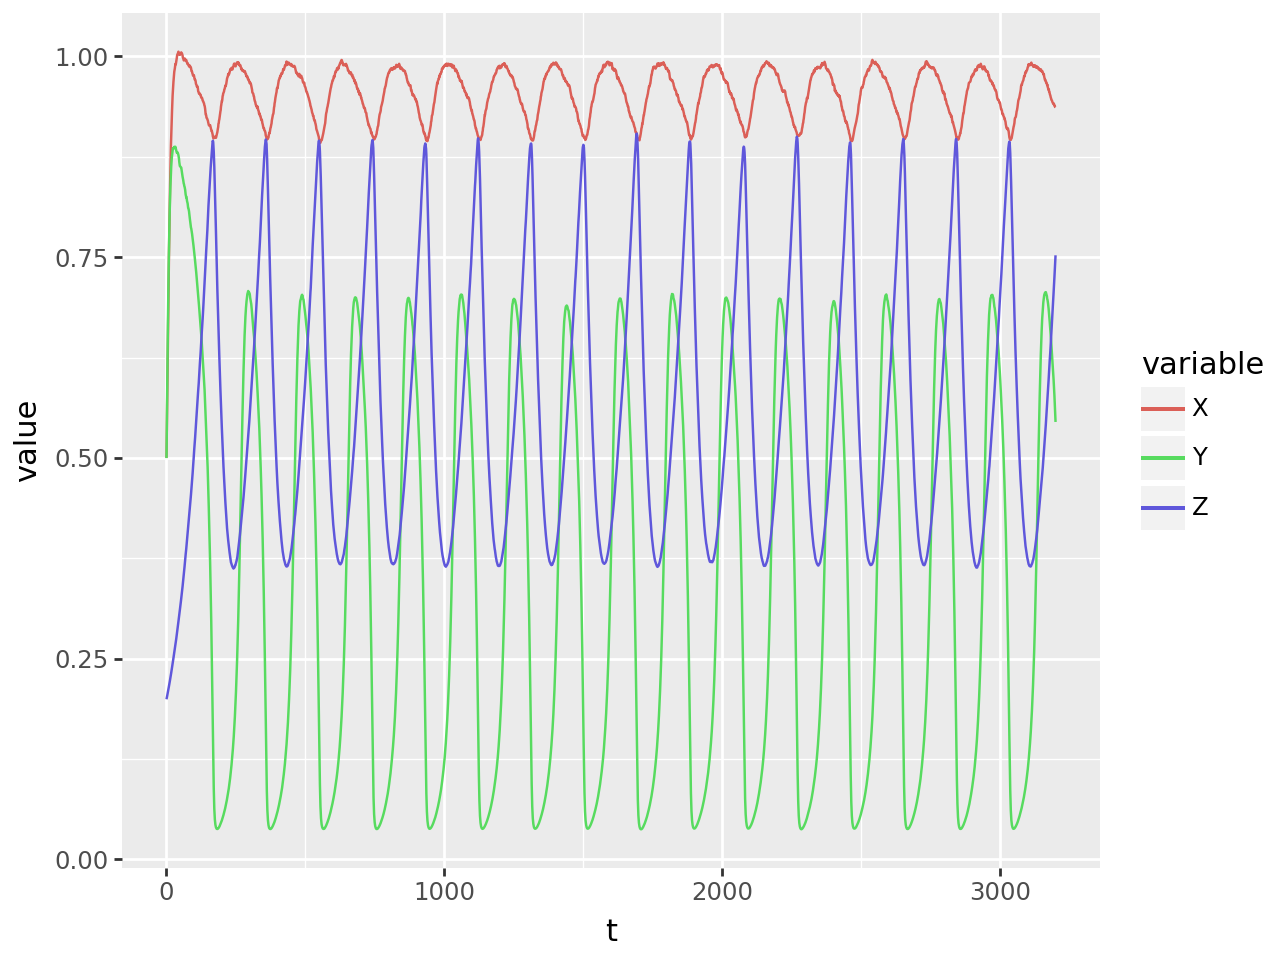

Salmon Population: 0.94
Lamprey Population: 0.54
Pinniped Population: 0.75


Salmon Carrying Capacity: 1.1


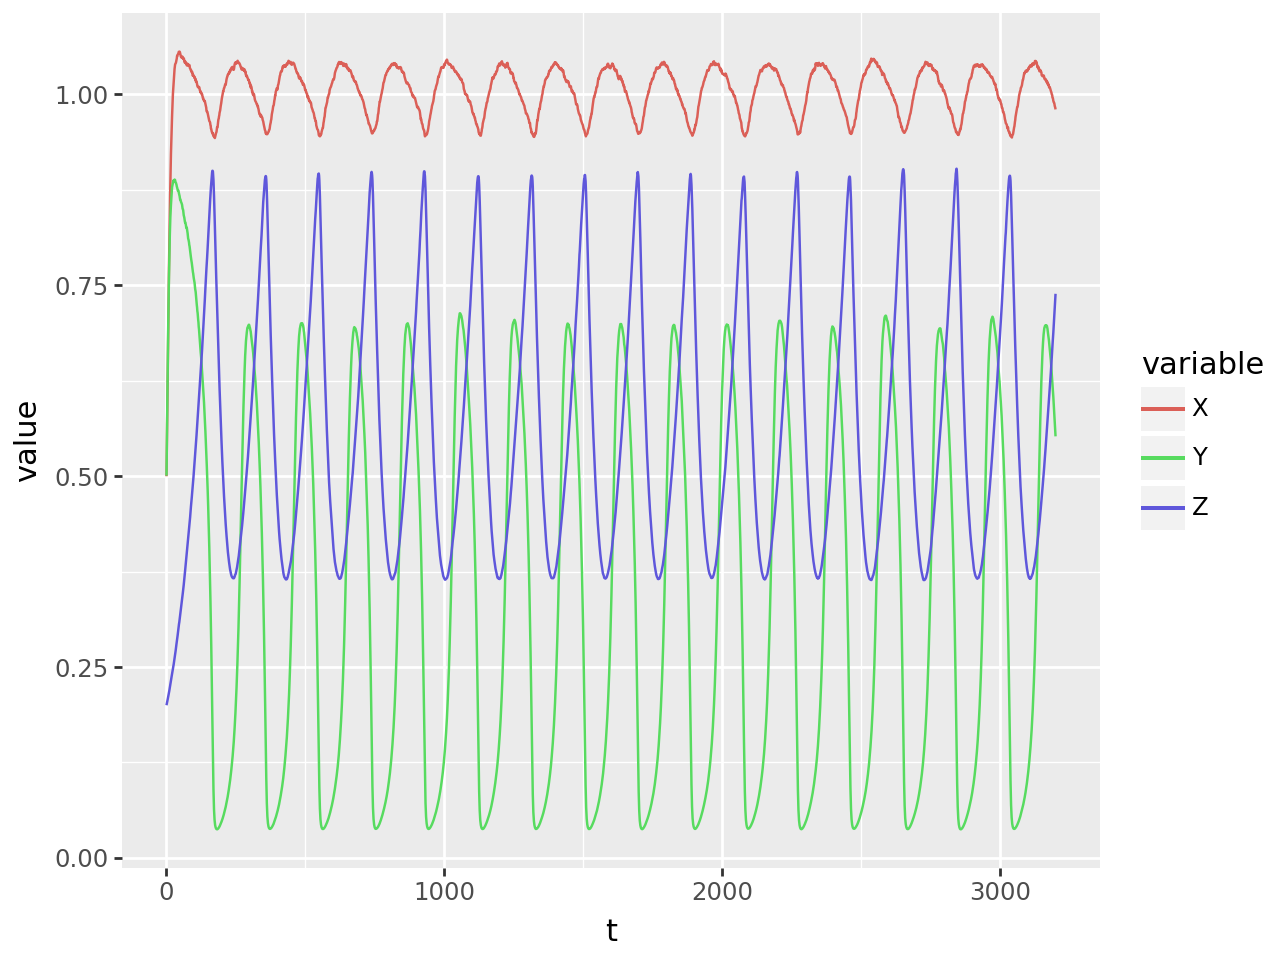

Salmon Population: 0.98
Lamprey Population: 0.55
Pinniped Population: 0.74


Salmon Carrying Capacity: 1.15


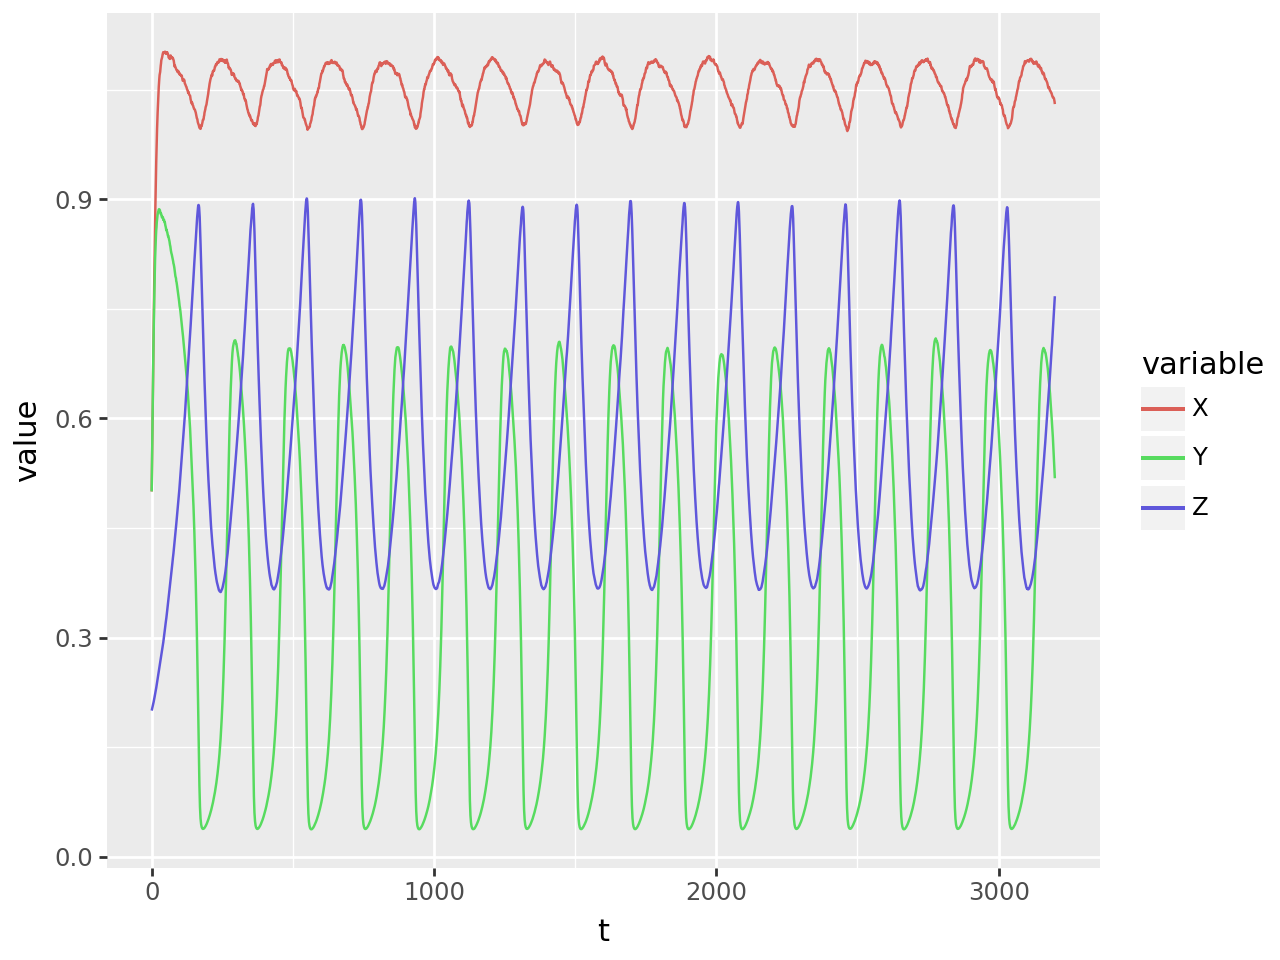

Salmon Population: 1.03
Lamprey Population: 0.52
Pinniped Population: 0.77


Salmon Carrying Capacity: 1.2


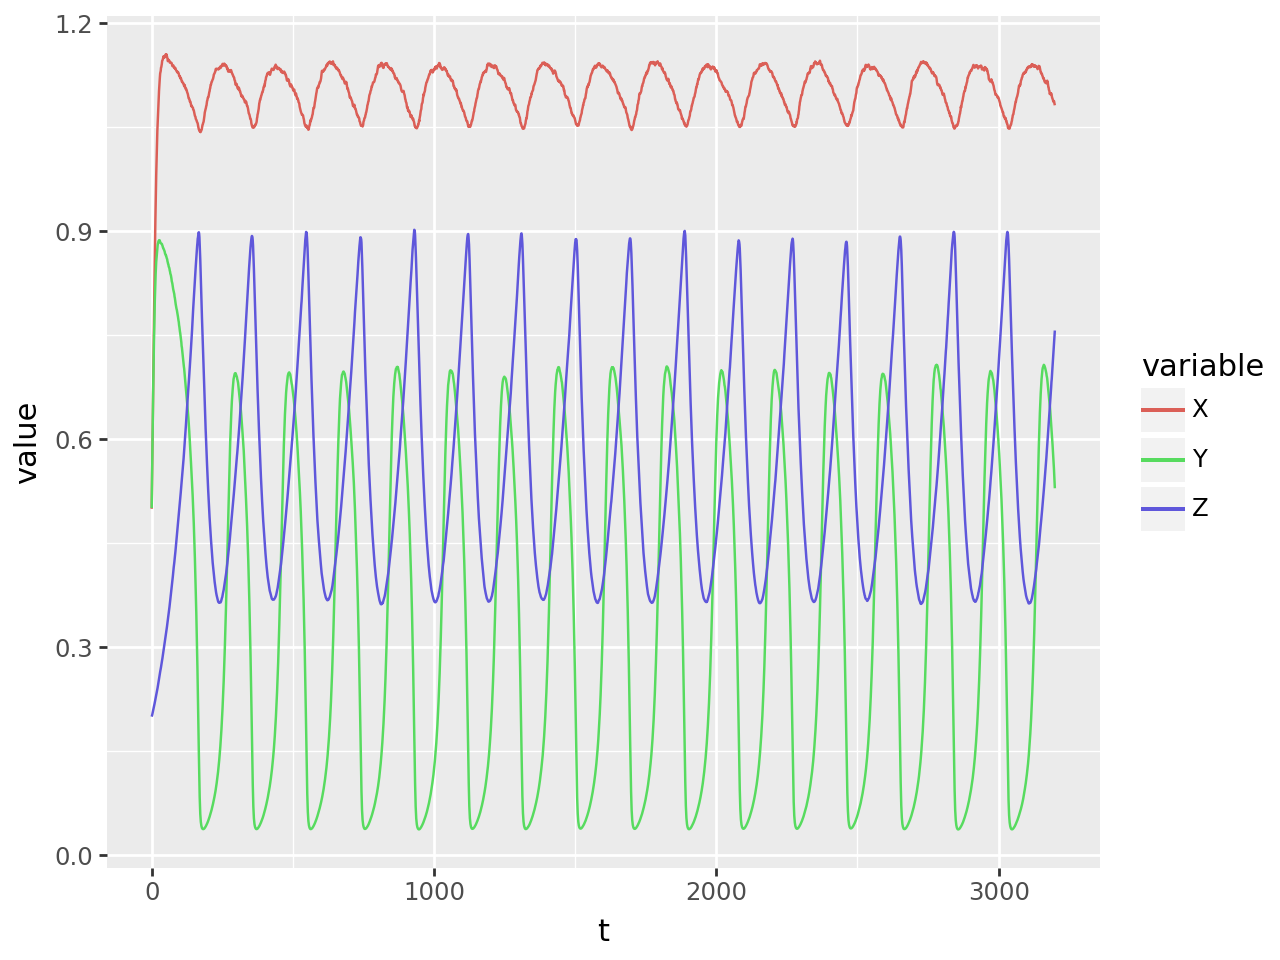

Salmon Population: 1.08
Lamprey Population: 0.53
Pinniped Population: 0.76


Salmon Carrying Capacity: 1.25


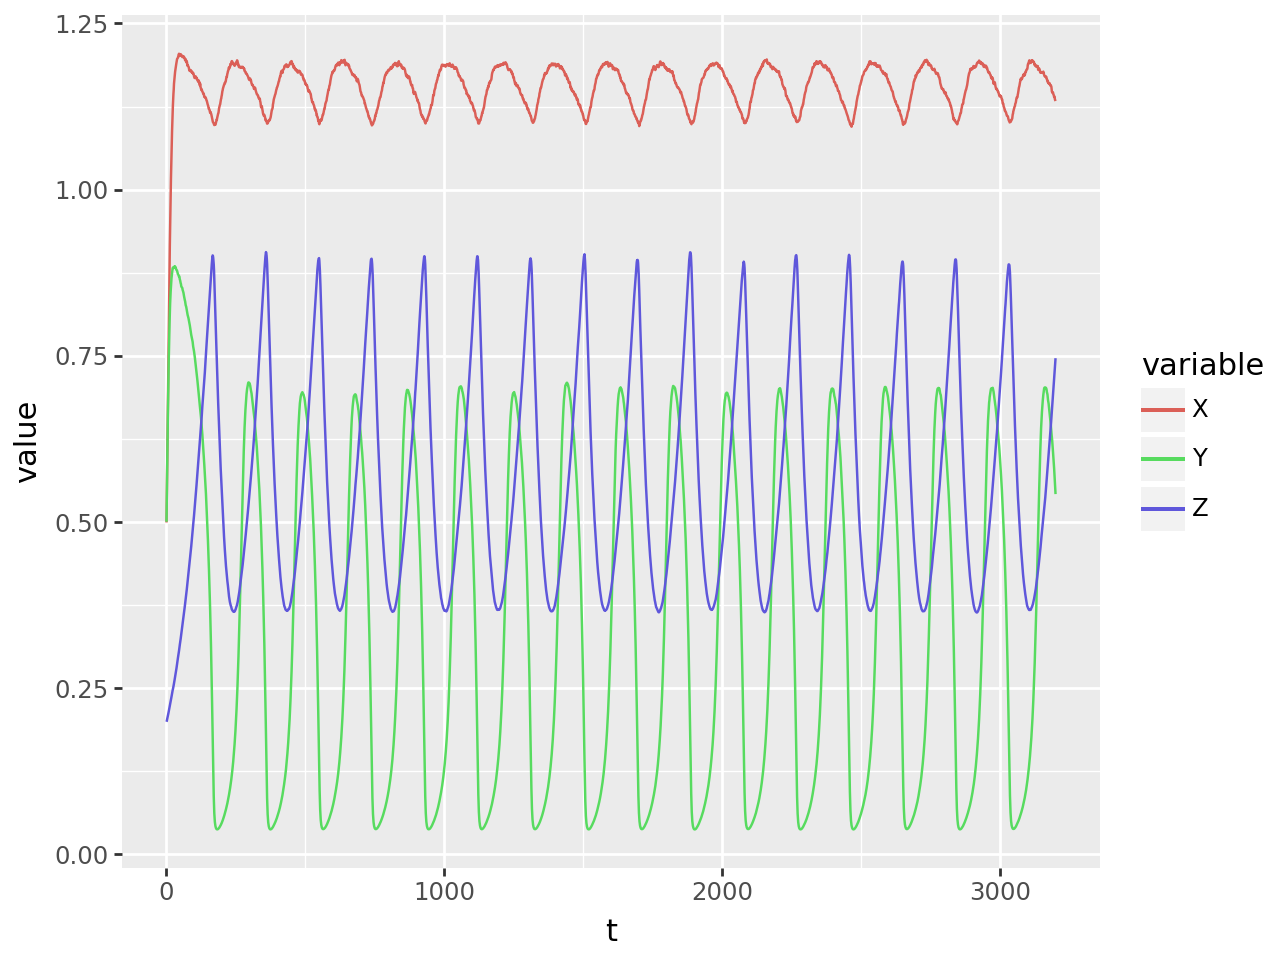

Salmon Population: 1.13
Lamprey Population: 0.54
Pinniped Population: 0.75




In [ ]:
simulate_k_change(n_timesteps, increment_range, "K_x")

Now, we try changing the lamprey's carrying capacity with different simulations, and we see some odd behavior. The final lamprey population does not have a direct correlation with the carrying capacity like the salmon, but rather if we take a closer look at the graph, it seems like the lamprey function shifts horizontally as we change K for it. Thus, optimization occurs when the shift allows the end population to be a peak.

Lamprey Carrying Capacity: 1.0


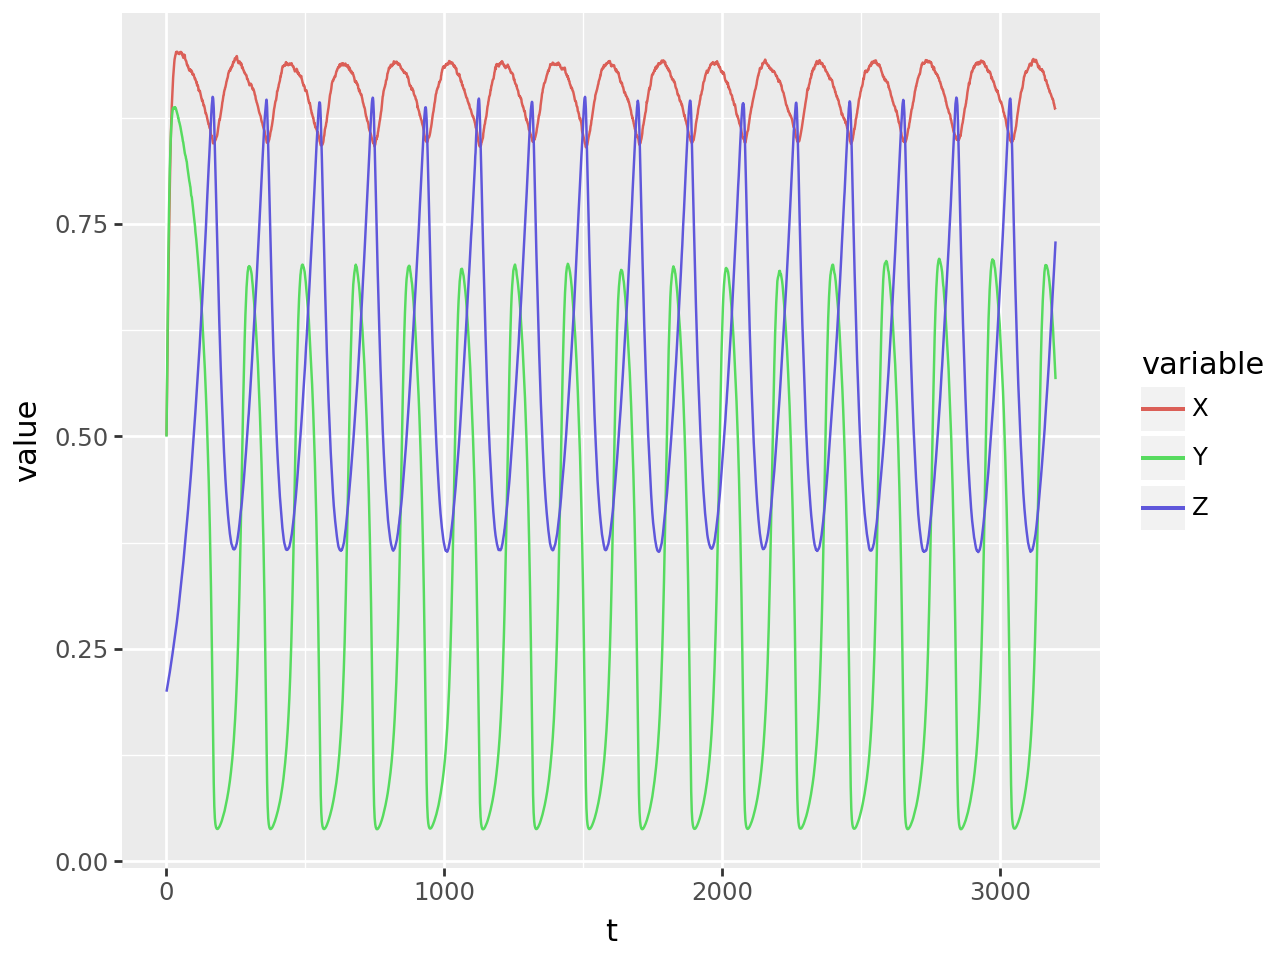

Salmon Population: 0.88
Lamprey Population: 0.57
Pinniped Population: 0.73


Lamprey Carrying Capacity: 1.05


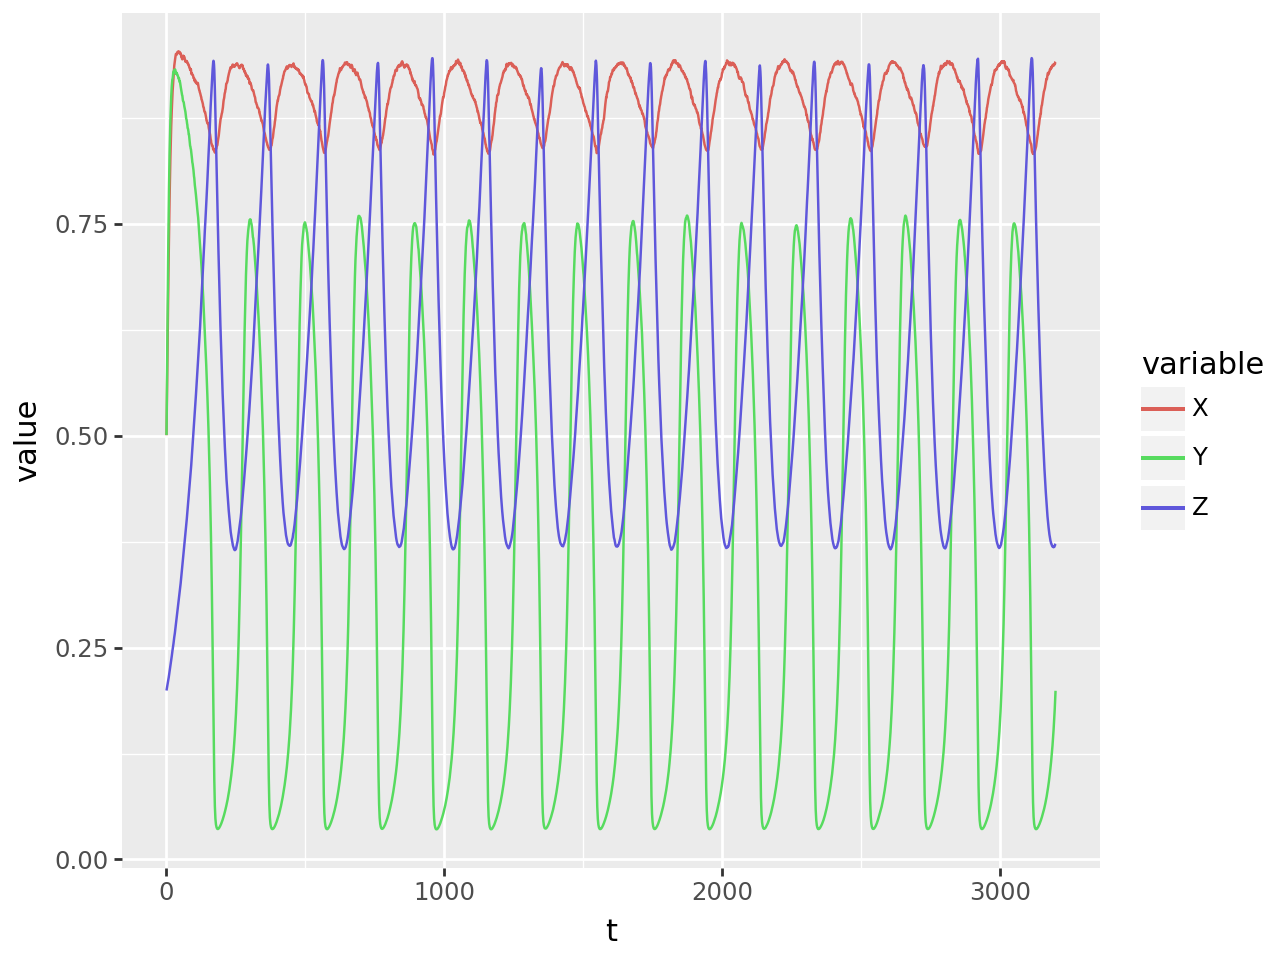

Salmon Population: 0.94
Lamprey Population: 0.20
Pinniped Population: 0.37


Lamprey Carrying Capacity: 1.1


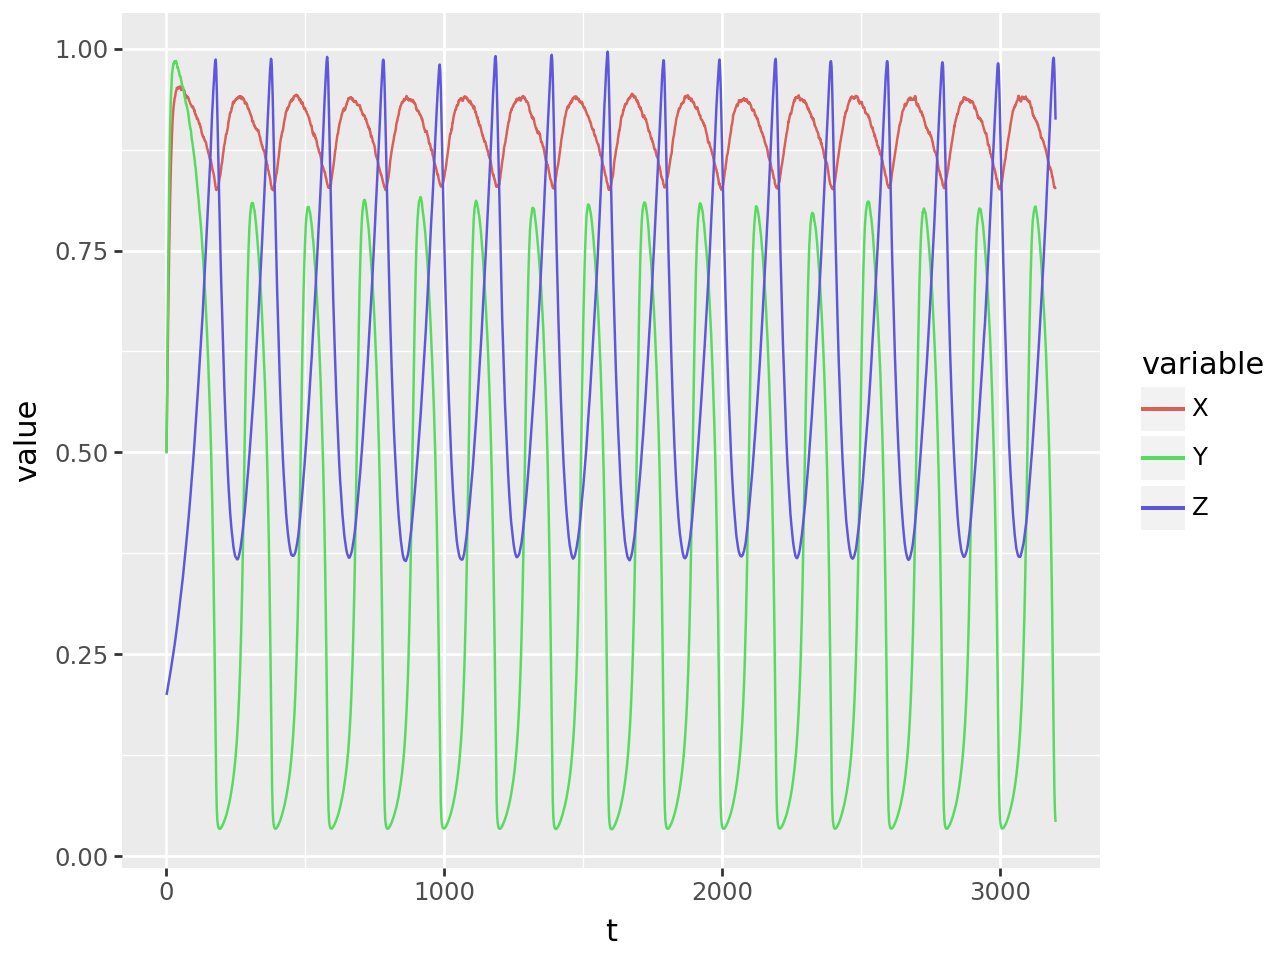

Salmon Population: 0.83
Lamprey Population: 0.04
Pinniped Population: 0.91


Lamprey Carrying Capacity: 1.15


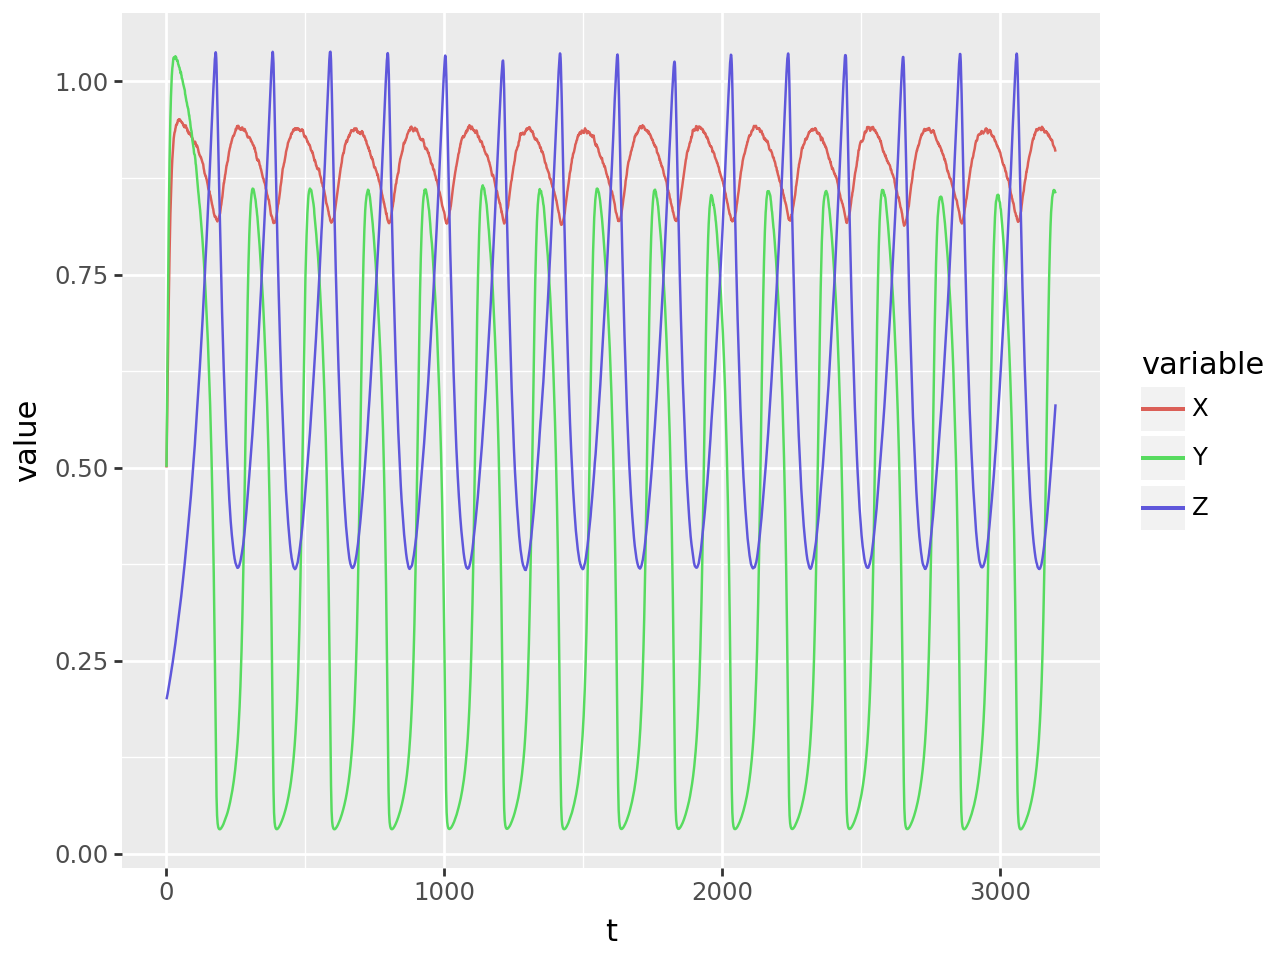

Salmon Population: 0.91
Lamprey Population: 0.86
Pinniped Population: 0.58


Lamprey Carrying Capacity: 1.2


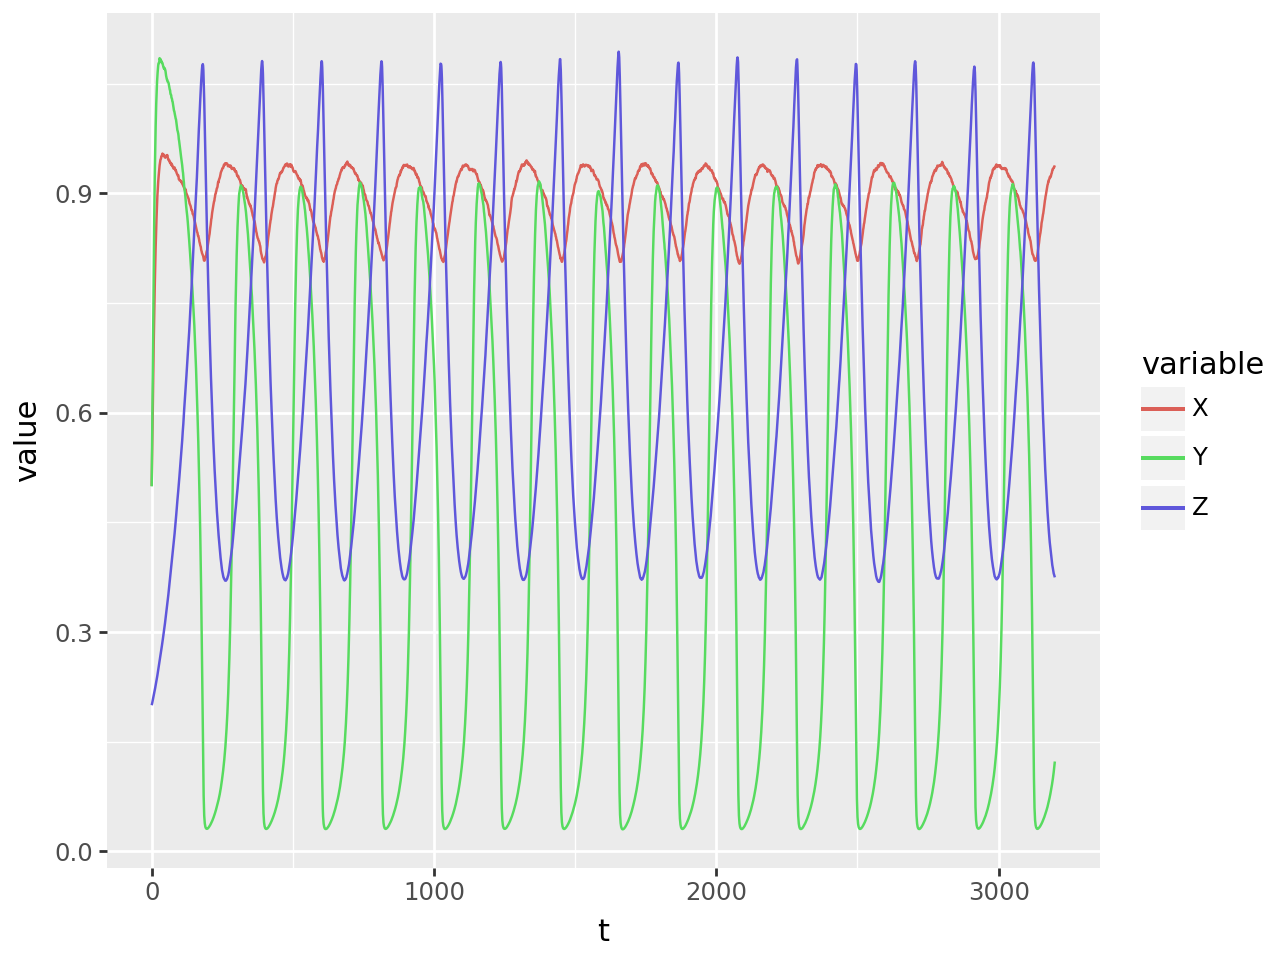

Salmon Population: 0.94
Lamprey Population: 0.12
Pinniped Population: 0.37


Lamprey Carrying Capacity: 1.25


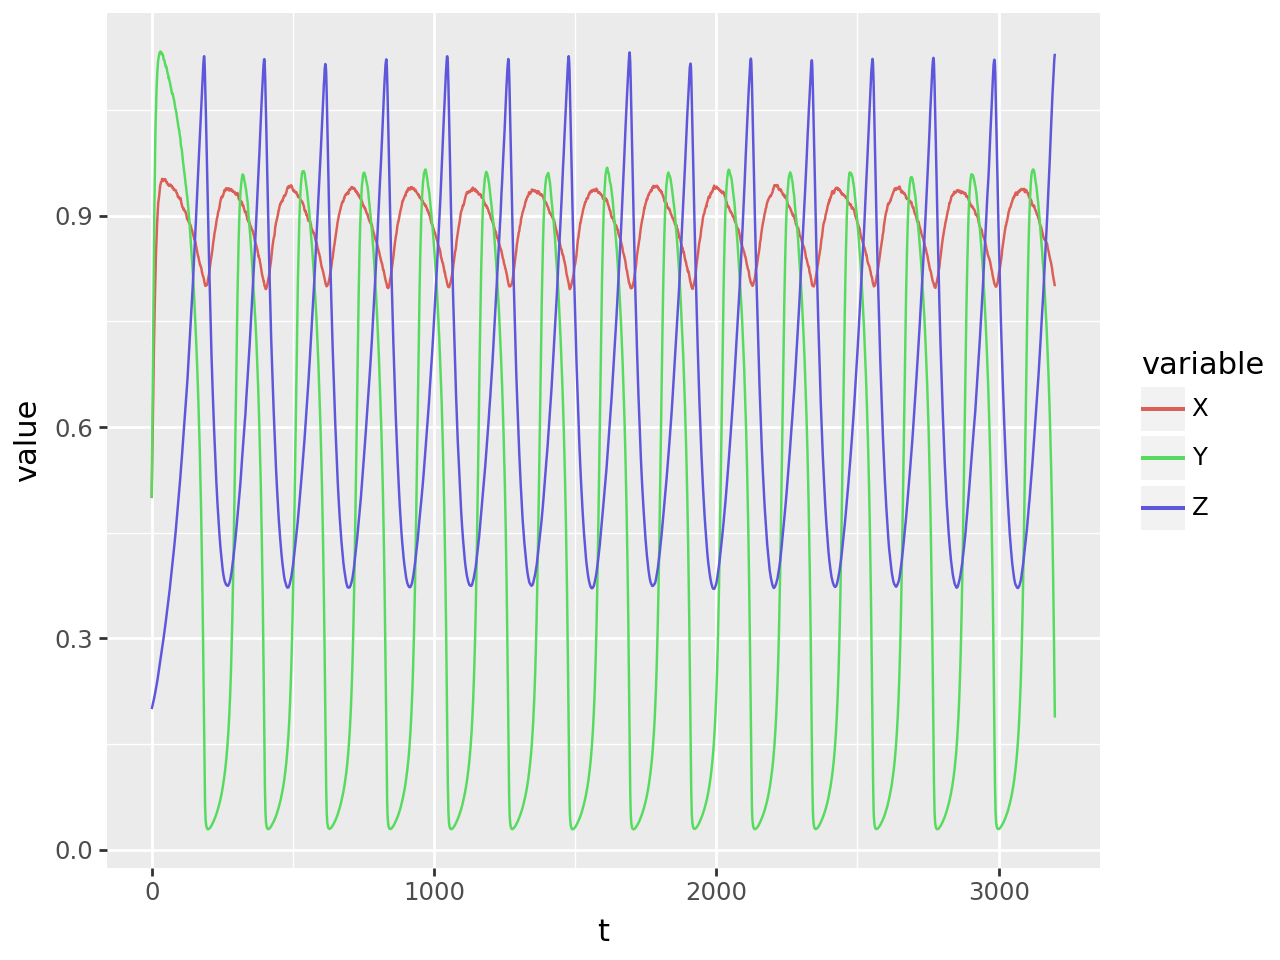

Salmon Population: 0.80
Lamprey Population: 0.19
Pinniped Population: 1.13




In [ ]:
simulate_k_change(n_timesteps, increment_range, "K_y")

Finally, we try changing the pinniped's carrying capacity. Contrary to the other two species, it seems that changing K for the pinnipeds does not alter its final population too greatly and no clear pattern can be seen.

Pinniped Carrying Capacity: 1.0


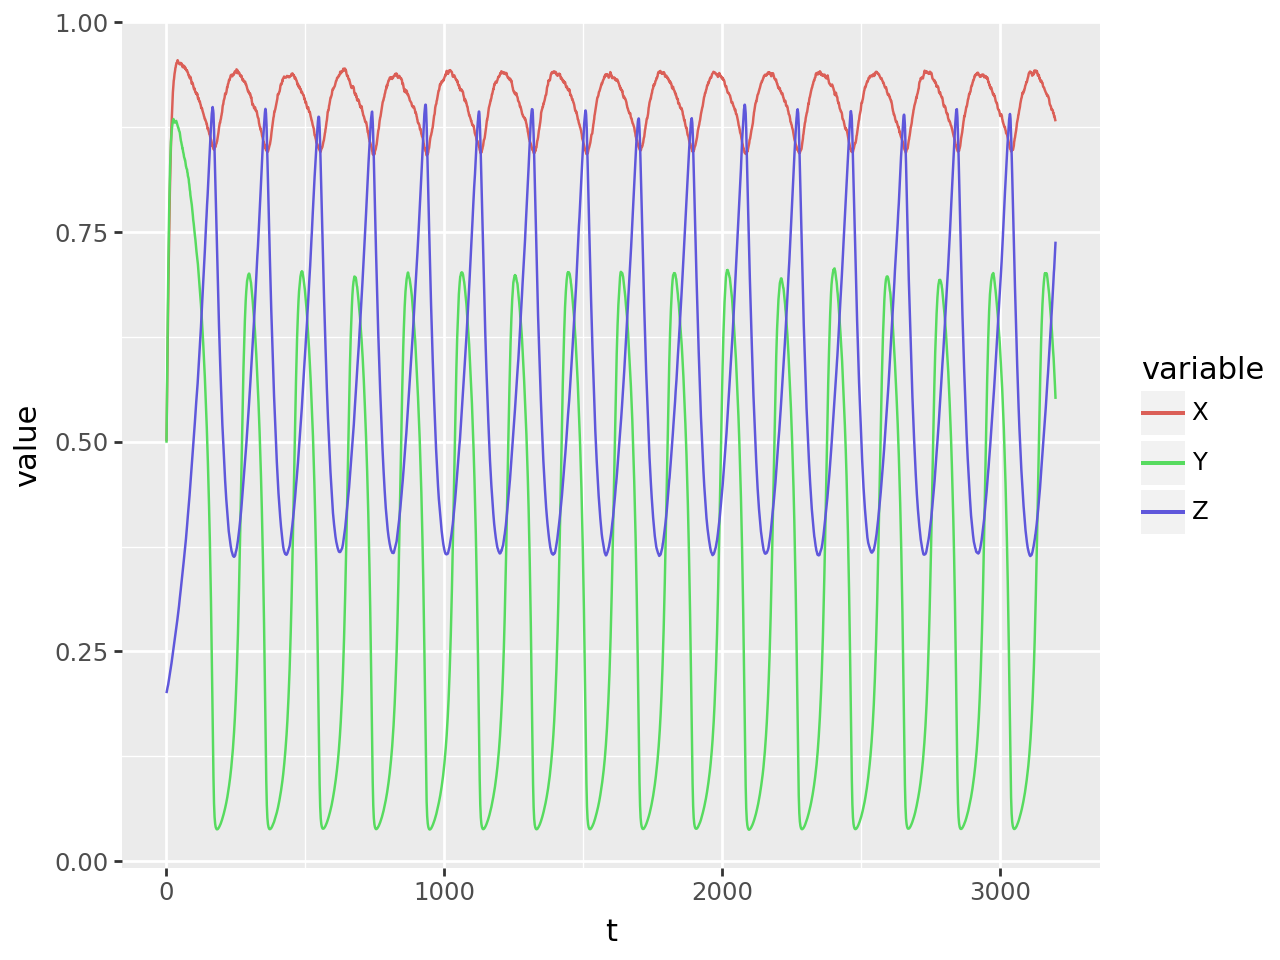

Salmon Population: 0.88
Lamprey Population: 0.55
Pinniped Population: 0.74


Pinniped Carrying Capacity: 1.05


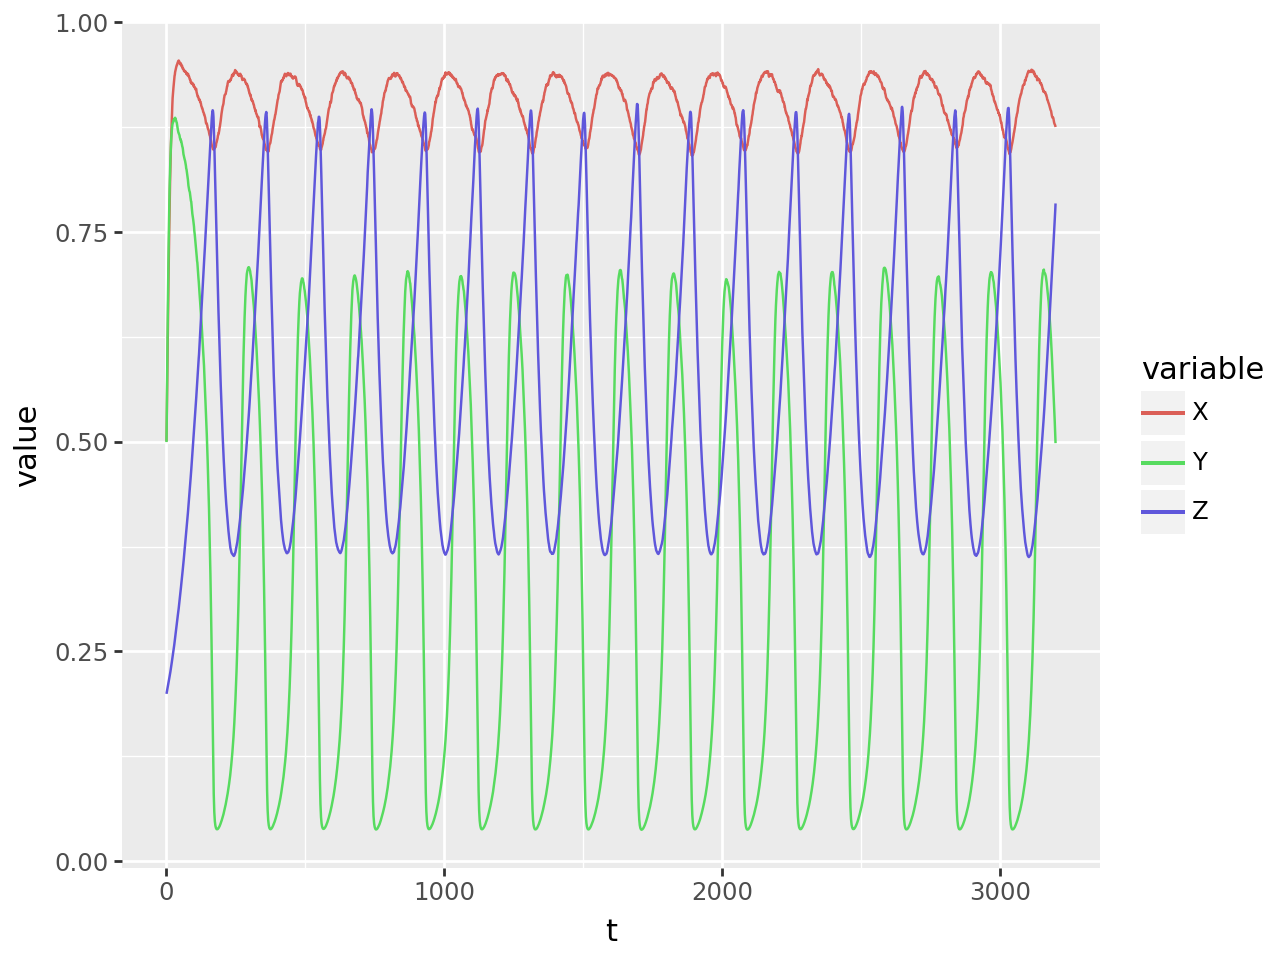

Salmon Population: 0.88
Lamprey Population: 0.50
Pinniped Population: 0.78


Pinniped Carrying Capacity: 1.1


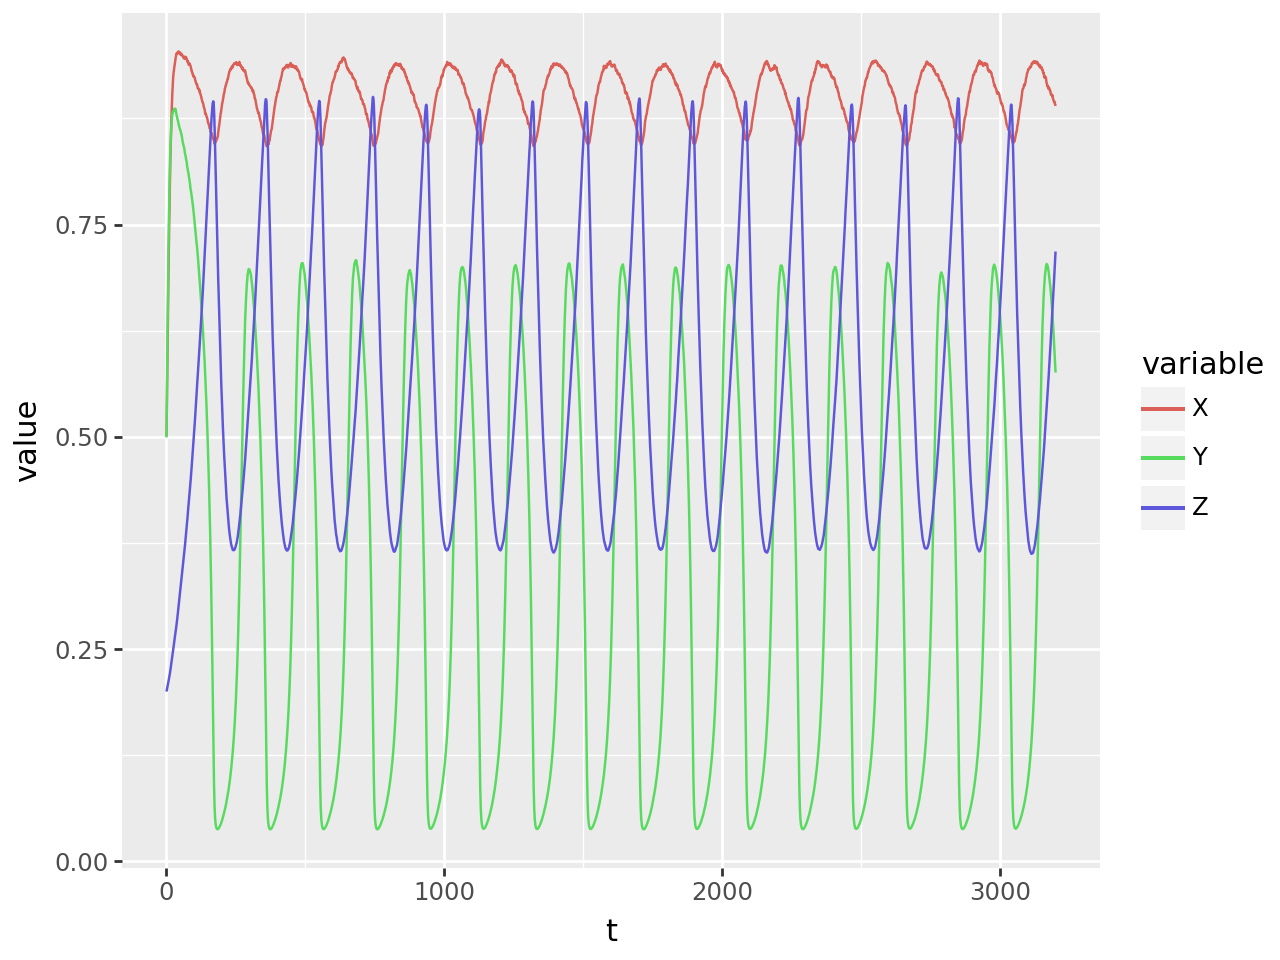

Salmon Population: 0.89
Lamprey Population: 0.58
Pinniped Population: 0.72


Pinniped Carrying Capacity: 1.15


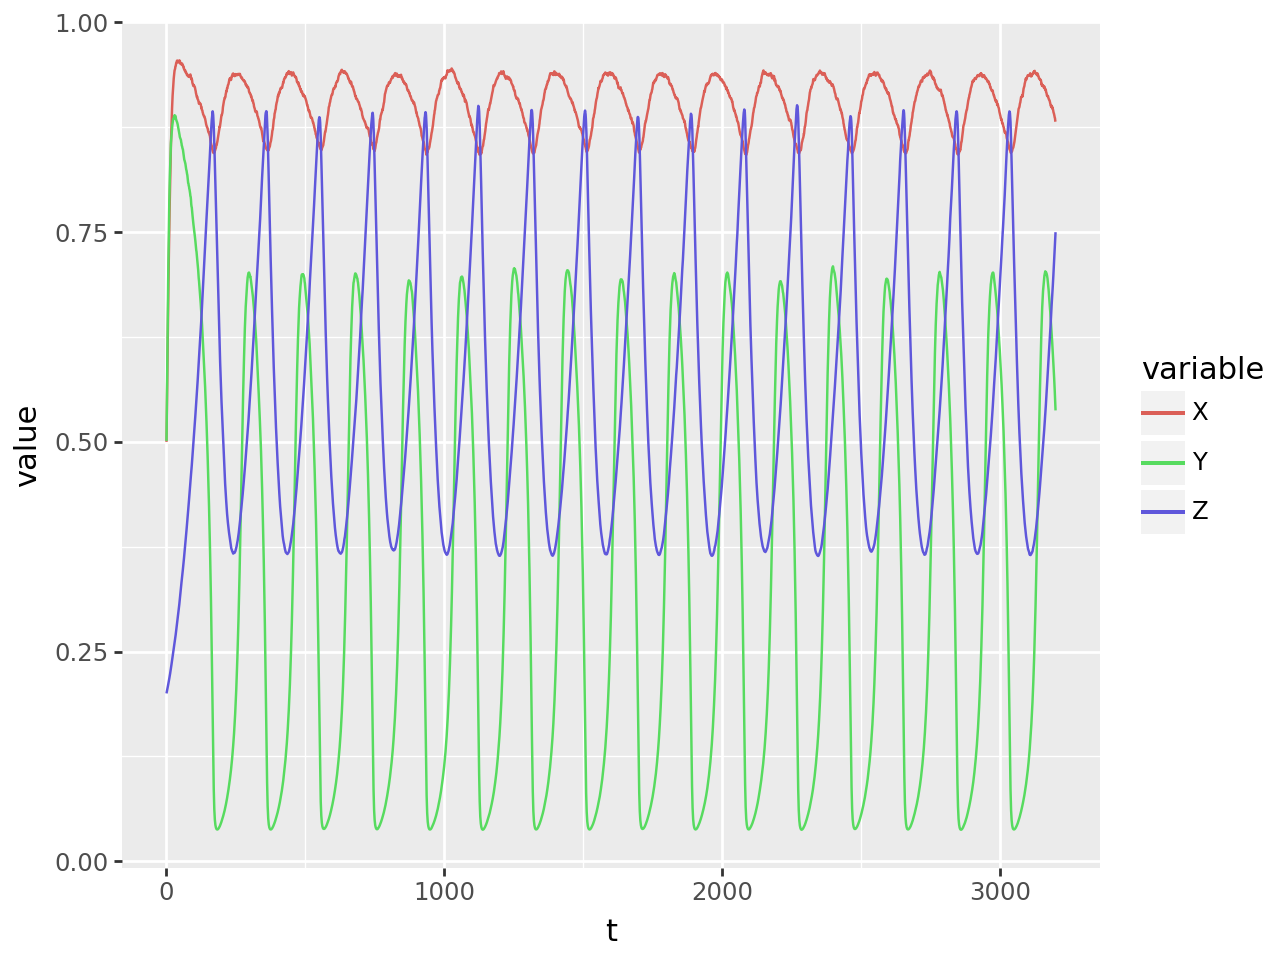

Salmon Population: 0.88
Lamprey Population: 0.54
Pinniped Population: 0.75


Pinniped Carrying Capacity: 1.2


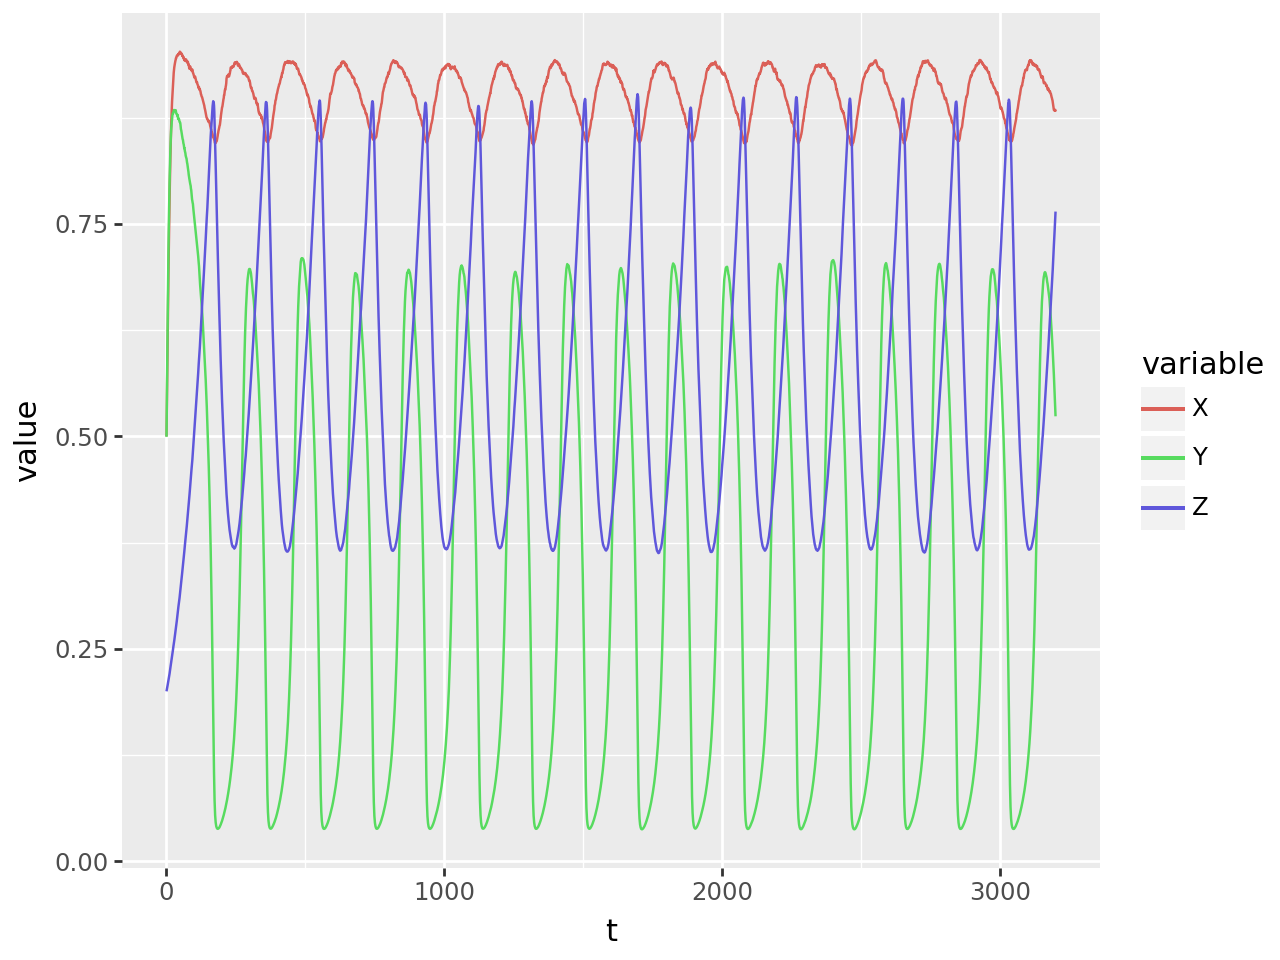

Salmon Population: 0.88
Lamprey Population: 0.52
Pinniped Population: 0.76


Pinniped Carrying Capacity: 1.25


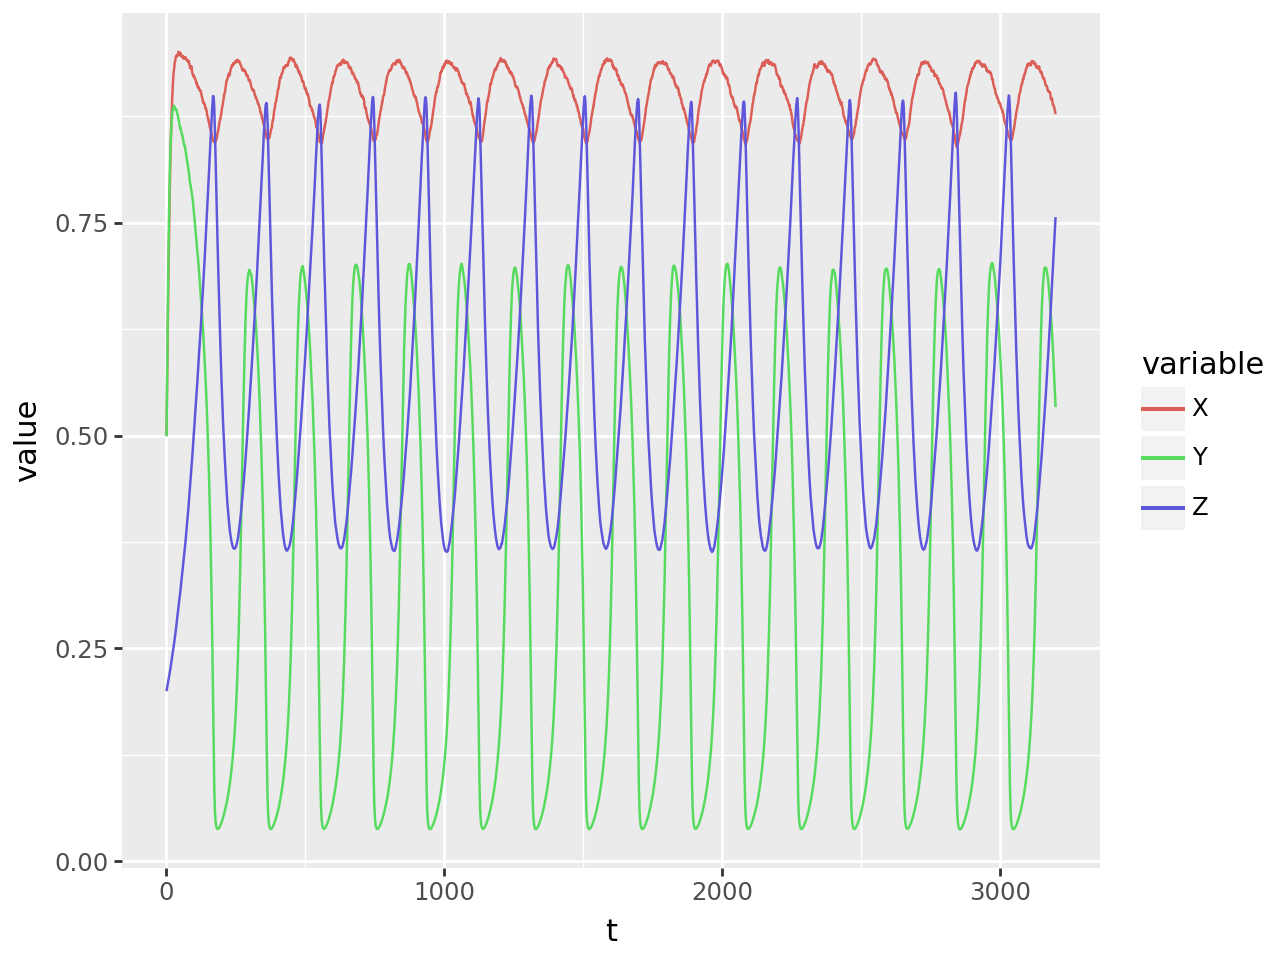

Salmon Population: 0.88
Lamprey Population: 0.53
Pinniped Population: 0.76




In [ ]:
simulate_k_change(n_timesteps, increment_range, "K_z")